<div style="background-color: #e6e6fa; color: #4b0082; padding: 10px; border-radius: 5px;">

# Multi-Agent Infinite Delivery

</div>

<div class="alert alert-block alert-info">

## Table of Contents
- **[Introduction](#Introduction)**
- **[Setup](#Setup)**
    - [Imports](#Imports)
    - [RewardConfig](#RewardConfig)
    - [Actions](#Actions)
    - [Environment](#Environment)
    - [TabularQAgent](#TabularQAgent)
    - [Trainer](#Trainer)
    - [Plotter](#Plotter)
    - [Tester](#Tester)
    - [Simulator](#Simulator)
- **[Training](#Training)**
- **[Testing](#Testing)**
- **[Simulation](#Simulation)**
</div>

<div class="alert alert-block alert-success">

## Introduction

</div>

In this notebook, we will explore the development and training of reinforcement learning agents for a grid world environment that simulates agents shuttling indefinitely between two locations (A and B) performing deliveries whilst avoiding collisions with one another. Agents can only spawn at either A (pickup) or B (delivery) and they are required to navigate from their starting point to A (if they did not spawn there), then to B repeatedly.

The agents are trained using tabular Q-learning to learn optimal behaviors for efficient delivery cycles with minimal collisions. The training is divided into two stages, beginning with single agent training to learn navigation and complete delivery cycles, followed by two agent training which introduces multi-agent interaction and collision management.

The notebook is designed to include interchangeable modules including reward configuration, actions, enrionment, agent, training, plotting, testing and simulation.

<div class="alert alert-block alert-success">

## Setup

</div>

<div class="alert alert-block alert-warning">

### Imports

</div>

The following libraries were used for the following purposes:
* **numpy**: Used for numerical operations and management of Q-tables or state vectors
* **matplotlib.pyplot**: Used for visualising evaluation metrics and multi agent system simulation
* **random**: Used for randomising decisions such as agent, A and B locations
* **time**: Used for benchmarking and tracking elapsed time during training in compliance with wall-time budget
* **defaultdict**: Used for efficiently creating and managing Q-tables with default initial values
* **itertools**: Used to generate combinations or permutations of A-B position pairs and agent start positions
* **os**: Used for file handling (e.g. saving/loading Q-tables)
* **clear_output**: Used to dynamically update multi agent system simulation
* **display**: Used to render dynamic HTML/Jupyter notebook outputs
* **HTML**: Used to format and display styled content for simulation output
* **product**: Used to compute every possible combination of agent spawn locations given A and B
* **Patch**: Used to create custom legend in matplotlib animation used for simulation

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import itertools
import os
import io
from collections import defaultdict
from IPython.display import clear_output, display, HTML
from itertools import product
from matplotlib.patches import Patch
from itertools import product, combinations
from PIL import Image

<div class="alert alert-block alert-warning">

### RewardConfig

</div>

The **`RewardConfig`** class is a modular reward structure used to train agents in the grid world environment. It contains reward and penalty values that guide the agent towards learning to perform efficient delivery cycles.

The class is fully modular and is easily modifiable without changing the environment or agent logic. Each variable in the class corresponds to a specific event or behavior consisting of collisions, movement and deliveries, all of which contribute to the agent's learning process.

In [2]:
class RewardConfig:
    """
    Encapsulates reward and penalty values associated with agent actions and their interactions with the environment
    
    Variables:
        step (int): Penalty for taking a step (to encourage efficiency)
        closer_to_target (int): Reward for moving closer to the current target (A or B)
        further_from_target (int): Penalty for moving away from the current target (A or B)
        walk_into_wall (int): Penalty for attempting to walk into a wall.
        collision (int): Penalty for colliding with another agent.
        avoid_collision (int): Reward for avoiding a collision with another agent in its 8-neighborhood.
        pickup (int): Reward for successfully reaching A without an item (picking up an item)
        delivery (int): Reward for successfully reaching B with an item (delivering an item)
        revisit_A (int): Penalty for revisiting A while already carrying an item
        revisit_B (int): Penalty for revisiting B while not carrying an item
        _20_step_delivery (int): Reward for completing a delivery cycle within 20 steps.
        no_collision_delivery (int): Reward for completing a delivery cycle without collisions
        perfect_delivery (int): Reward for completing a delivery cycle within 20 steps and with no collisions
    """
    def __init__(self):
        """
        Initializes the reward configuration
        """
        self.step = -1  # penalty per agent step
        self.closer_to_target = 1  # reward for moving closer to current target
        self.further_from_target = -2  # penalty for moving away from current target
        self.walk_into_wall = -50  # penalty for walking into a wall
        self.collision = -200  # penalty for colliding with another agent
        self.avoid_collision = 3  # reward for avoiding collision with another agent in 8-neighborhood
        self.pickup = 15  # reward for picking up item at A
        self.delivery = 15  # reward for delivering item at B
        self.revisit_A = -5  # penalty for revisiting A when already carrying an item
        self.revisit_B = -5  # penalty for revisiting B when not carrying an item
        self._20_step_delivery = 50  # reward for completing delivery in less than 20 steps
        self.no_collision_delivery = 50  # reward for completing delivery without collisions
        self.perfect_delivery = 100  # reward for completing delivery in less than 20 steps AND without collisions

    def get(self, reward_type):
        """
        Retrieves the reward or penalty value associated with the reward or penalty type

        Parameters:
            reward_type (str): Name of the reward / penalty

        Returns:
            int: Corresponding reward or penalty value
        """
        return getattr(self, reward_type)

<div class="alert alert-block alert-warning">

### Actions

</div>

The **`Actions`** class defines the four possible discrete movement directions that an agent is able to perform within the grid world environment - `Up`, `Down`, `Left` and `Right`. These are mapped to integer values ranging from `0` to `3`, making them compatible with numerical indexing in Q-tables.

In [3]:
class Actions:
    """
    Defines the discrete set of movement actions available to agents in the grid world environment

    Variables:
        UP (int): Action representing movement upwards (0)
        DOWN (int): Action representing movement downwards (1)
        LEFT (int): Action representing movement to the left (2)
        RIGHT (int): Action representing movement to the right (3)
    """
    UP = 0
    DOWN = 1
    LEFT = 2
    RIGHT = 3

    @staticmethod
    def get_action_name(action):
        if action == Actions.UP:
            return "Up"
        elif action == Actions.DOWN:
            return "Down"
        elif action == Actions.LEFT:
            return "Left"
        elif action == Actions.RIGHT:
            return "Right"
        else:
            return "Invalid Action"

<div class="alert alert-block alert-warning">

### Environment

</div>

The **`Environment`** class simulates a multi-agent grid where agents learn to perform repeated deliveries between two fixed locations indefinitely between two fixed locations, **`A`** and **`B`**, while avoiding head-on collisions with agents moving in the opposite direction.

The environment is designed to be modular and configurable, allowing for custom reward configuration and blocked cell placement. Neigbouring cells checked for agents moving in the opposite direction is implemented via an 8-neighborhood sensor that enables agents to detect potential collisions. The environment continuously tracks agent positions, delivery progress and interactions within the environment.

In [4]:
class Environment:
    """
    Simulates a grid-world environment for multi-agent pickup and delivery
    
    Variables:
        size_x (int): Number of columns in the grid (horizontal size)
        size_y (int): Number of rows in the grid (vertical size)
        num_agents (int): Number of agents in the environment
        agents (list of dict): List storing each agent's state with keys "position", "carrying", and "direction"
        collisions (list of int): Number of collisions for each agent for a delivery cycle
        total_collisions (int): Total number of collisions for current episode
        collided (list of bool): Flags indicating if each agent has collided in the current step
        deliveries (list of int): Number of completed deliveries by each agent
        agent_steps (list of int): Number of steps taken by each agent for a delivery cycle
        total_steps (list of int): Total number of steps taken by each agent
        start_loc (list of tuple): Initial starting positions for each agent
        dones (list of bool): Flags indicating whether an agent has completed a delivery cycle
        blocked_cells (list of tuple): Coordinates of cells that are blocked
        reward_config (RewardConfig): Reward configuration for each agent action and environment interaction
        A (tuple): Coordinates of the pickup location
        B (tuple): Coordinates of the delivery location
    """
    def __init__(self, size_x=5, size_y=5, num_agents=4, blocked_cells=None):
        """
        Initialises the environment with a configurable grid size, number of agents, configurable reward schema and optional blocked cells
        
        Parameters:
            size_x (int): Number of columns in the grid (horizontal size)
            size_y (int): Number of rows in the grid (vertical size)
            num_agents (int): Number of agents in the environment
            blocked_cells (list of tuple, optional): Coordinates of cells that are blocked
        """
        self.size_x = size_x
        self.size_y = size_y
        self.num_agents = num_agents
        self.agents = None
        self.collisions = None
        self.total_collisions = None
        self.collided = None
        self.deliveries = None
        self.agent_steps = None
        self.total_steps = [0] * self.num_agents
        self.start_loc = None
        self.dones = None
        self.reached_B = None
        self.blocked_cells = blocked_cells or []
        self.reward_config = RewardConfig()
        self.actions = Actions()
        self.reset()

    def reset(self, custom_A=None, custom_B=None, custom_spawn=None):
        """
        Resets the environment to an initial state, optionally allowing for custom pickup (A), delivery (B) and agent spawn locations.

        Parameters:
            custom_A (tuple, optional): Custom fixed location (y, x) for pickup location A
            custom_B (tuple, optional): Custom fixed location (y, x) for delivery location B
            custom_spawn (list of tuple, optional): List of initial spawn locations for each agent. Each element is a (y, x) tuple
            
        Returns:
            list: A list of state tuples representing the initial state of each agent after reset
        """

        # Initialising starting positions for pickup (A) and delivery (B)
        all_positions = [(y, x) for y in range(self.size_y) for x in range(self.size_x)]
        positions = random.sample(all_positions, 2)
        self.A = positions[0]
        self.B = positions[1]

        # Setting custom A and B positions optionally
        if custom_A:
            self.A = custom_A

        if custom_B:
            self.B = custom_B

        # Resetting all variables for new episode
        self.collisions = [0] * self.num_agents
        self.total_collisions = 0
        self.total_steps = [0] * self.num_agents
        self.collided = [False] * self.num_agents
        self.deliveries = [0] * self.num_agents
        self.agent_steps = [0] * self.num_agents
        self.dones = [False] * self.num_agents
        self.start_loc = [] * self.num_agents
        self.reached_B = [False] * self.num_agents

        # Initialising starting positions (A or B) for each agent
        self.agents = []
        for i in range(self.num_agents):

            # Initially custom start positions for each agent optionally
            if custom_spawn:
                start_loc = custom_spawn[i]
            else:
                start_loc = random.choice([self.A, self.B])
                
            self.start_loc.append(start_loc)

            # Initialising agent information
            carrying = True if start_loc == self.A else False
            self.agents.append({
                "position": start_loc,
                "carrying": carrying,
                "direction": "A_to_B" if start_loc == self.A else "B_to_A"
            })

        return self.get_state()

    def step(self, agent_idx, action):
        """
        Executes a single step for one agent given its action.
        
        Updates agent state, computes reward, handles deliveries and collisions.

        Parameters:
            agent_idx (int): The index of the current performing agent
            action (int): The action to perform (0 = Up, 1 = Down, 2 = Left, 3 = Right)
        
        Returns:
            state (tuple): The updated state of the agent after performing the action
            reward (float): The computed reward for the action
        """

        # Initialising initial reward and current performing agent
        reward = 0
        agent = self.agents[agent_idx]

        # Computing agent's position after action
        old_position = agent["position"]
        new_position = self.get_new_position(old_position, action)

        # Incrementing agent steps
        self.agent_steps[agent_idx] += 1
        self.total_steps[agent_idx] += 1

        # Penalizing agent if it walks into a wall (position unchanged)
        if old_position == new_position:
            reward += self.reward_config.get("walk_into_wall")

        # Computing agent's old and new distance from current target (A or B)
        if not agent["carrying"]:
            target = self.A
        else:
            target = self.B

        old_distance = abs(old_position[0] - target[0]) + abs(old_position[1] - target[1])
        new_distance = abs(new_position[0] - target[0]) + abs(new_position[1] - target[1])
                
        if new_distance < old_distance:

            # Rewarding agent for moving closer to its current target (A or B)
            reward += self.reward_config.get("closer_to_target")
        else:

            # Penalizing agent for moving away from its current target (A or B)
            reward += self.reward_config.get("further_from_target")

        # Computing whether a collision occurred
        for j in range(self.num_agents):
            if (agent_idx != j and new_position == self.agents[j]["position"] and agent["direction"] != self.agents[j]["direction"] and new_position != self.A and new_position != self.B
               and not self.collided[agent_idx] and not self.collided[j]):

                # Incrementing agent and total collisions
                self.collisions[agent_idx] += 1
                self.total_collisions += 1

                # Set both agents in collision as collided to only allow pairwise collisions
                self.collided[agent_idx] = True
                self.collided[j] = True

                # Penalizing agent for collision
                reward += self.reward_config.get("collision")
                break

        # Rewarding agent for avoiding collision
        if any(self.get_opposite_neighbors(agent_idx)) and not self.collided[agent_idx]:
            reward += self.reward_config.get("avoid_collision")

        # Updating agent position
        agent["position"] = new_position

        # Agent is not carrying an item and is at pickup location
        if agent["position"] == self.A and not agent["carrying"]:

            # Updating agent status
            agent["carrying"] = True
            agent["direction"] = "A_to_B"
            reward += self.reward_config.get("pickup")

            # If agent's starting position was A and it's not carrying an item anymore, it has completed a delivery cycle
            # if self.start_loc[agent_idx] == self.A:
            #     self.dones[agent_idx] = True

        # Agent is carrying an item and is at delivery location
        elif agent["position"] == self.B and agent["carrying"]:

            # Updating agent status
            agent["carrying"] = False
            agent["direction"] = "B_to_A"

            # Incrementing number of agent deliveries
            self.deliveries[agent_idx] += 1

            # If agent's starting position is B and it's carrying an item, it has completed a delivery cycle (B->A->B)
            # OR if agent's starting position is A and it has reached B before, then it has completed a delivery cycle (A->B->A->B)
            if self.start_loc[agent_idx] == self.B or (self.start_loc[agent_idx] == self.A and self.reached_B[agent_idx]):

                # Indicate current performing agent has completed a delivery cycle 
                self.dones[agent_idx] = True
                
                # Rewarding agent for performing a perfect delivery (no collisions and under 20 steps)
                if self.collisions[agent_idx] == 0 and self.agent_steps[agent_idx] < 20:
                    reward += self.reward_config.get("perfect_delivery")
    
                # Rewarding agent for performing a delivery without collisions
                elif self.collisions[agent_idx] == 0:
                    reward += self.reward_config.get("no_collision_delivery")
    
                # Rewarding agent for performing a delivery under 20 steps
                elif self.agent_steps[agent_idx] < 20:
                    reward += self.reward_config.get("_20_step_delivery")
    
                # Rewarding agent for performing a typical delivery (with collisions and over 20 steps)
                else:
                    reward += self.reward_config.get("delivery")

                # Resetting agent collisions and steps for new delivery cycle
                self.collisions[agent_idx] = 0
                self.agent_steps[agent_idx] = 0

            # Agent started at A and has reached B for the first time
            elif self.start_loc[agent_idx] == self.A and not self.reached_B[agent_idx]:

                # Indicate current performing agent that started at A reached B for the first time, it will start the delivery cycle here
                self.reached_B[agent_idx] = True

                # Reset agent's step count for start of delivery cycle B->A->B
                self.agent_steps[agent_idx] = 0
                
        # Penalizing agent for carrying an item and revisiting A
        elif agent["position"] == self.A and agent["carrying"]:
            reward += self.reward_config.get("revisit_A")

        # Penalizing agent for not carrying an item and revisiting B
        elif agent["position"] == self.B and not agent["carrying"]:
            reward += self.reward_config.get("revisit_B")

        return self.get_state()[agent_idx], reward
        
    def get_new_position(self, position, action):
        """
        Computes the new position after applying the given action while considering grid boundaries and avoiding blocked cells.

        Actions are defined as such (0 = Up, 1 = Down, 2 = Left, 3 = Right)

        Parameters:
            position (tuple): The coordinates (y, x) of the agent
            action (int): The action of the agent
        
        Returns:
            tuple: The updated coordinates of the agent
        """

        # Initialising coordinates of the agent
        y, x = position

        # Performing action and updating coordinates
        if action == Actions.UP:
            y = max(0, y - 1)
        elif action == Actions.DOWN:
            y = min(self.size_y - 1, y + 1)
        elif action == Actions.LEFT:
            x = max(0, x - 1)
        elif action == Actions.RIGHT:
            x = min(self.size_x - 1, x + 1)

        # If updated position is a blocked cell, return original position
        if (y, x) in self.blocked_cells:
            return position
            
        return (y, x)

    def get_target_dir(self, pos, target):
        """
        Computes the vector direction from the given agent's position to its target (A or B).

        Parameters:
            pos (tuple): The coordinates (y, x) of the agent
            target (tuple): The coordinates (y, x) of the agent's current target (A or B)

        Returns:
            tuple: The vector direction from the agent's position to the target
        """
        return (target[0] - pos[0], target[1] - pos[1])
        
    def get_opposite_neighbors(self, agent_idx):
        """
        Scans the 8-neighborhood of the given agent and returns a binary vector that indicates whether an agent 
        moving in the opposite direction is present in each cell (1) or not (0).
        
        Implemented as part of the sensor option "State of neighbouring cells checked for agents of opposite type"

        Parameters:
            agent_idx (int): The index of an agent

        Returns:
            tuple: A binary tuple of length 8 where each element corresponds to one of the agent's 8-neighborhood cells.
                   A value of 1 indiciates the presence of an uncollided agent moving in the opposite direction in that cell,
                   and 0 indicates absence, given that the cell is not the position of A or B
        """

        # Initialising agent position and direction
        agent = self.agents[agent_idx]
        y, x = agent.get("position")
        agent_direction = agent.get("direction")

        # Initialising coordinates of agent's 8-neighborhood
        neighbors = [
            (y-1, x-1), (y-1, x), (y-1, x+1),
            (y,   x-1),           (y,   x+1),
            (y+1, x-1), (y+1, x), (y+1, x+1)
        ]

        # Filtering neighbors that are within the boundaries of the grid
        valid_neighbors = [n for n in neighbors if 0 <= n[0] < self.size_y and 0 <= n[1] < self.size_x]

        # Computing neighbors that are moving in the opposite direction
        opposite_neighbors = []
        for n in valid_neighbors:
            for j, other_agent in enumerate(self.agents):
                if j != agent_idx and other_agent["position"] == n and other_agent["direction"] != agent_direction and other_agent["position"] != self.A and other_agent["position"] != self.B and not self.collided[j]:
                    opposite_neighbors.append(n)
                    break

        sensor_reading = [0] * 8
        for i, n in enumerate(neighbors):
            if n in opposite_neighbors:
                sensor_reading[i] = 1

        return tuple(sensor_reading)

    def reset_collision(self):
        """
        Resets the collision flags for all agents after each step.
        
        Ensures that each agent can only register one collision per step.
        
        For example, if four agents move into the same cell where two are moving from A to B
        and two from B to A, only two pairwise collisions are counted.
        """
        self.collided = [False] * self.num_agents

    def get_state(self):
        """
        Initialises the current state representation for all agents.
        
        Each state includes agent position, whether they are carrying an item, A and B positions, vector to current target (A or B),
        and 8-neighborhood binary vector of agents moving in the opposite direction.

        Returns:
            list of tuple: The current state representation for all agents
        """
        states = []
        for i in range(self.num_agents):
            agent = self.agents[i]
            target = self.B if agent["carrying"] else self.A
            direction = self.get_target_dir(agent["position"], target)
            state = (
                agent["position"][0], agent["position"][1],
                int(agent["carrying"]),
                self.A[0], self.A[1],
                self.B[0], self.B[1],
                direction[0], direction[1]
            )

            opposite_neighbors = self.get_opposite_neighbors(i)
            state = state + opposite_neighbors
            states.append(state)
        return states

<div class="alert alert-block alert-warning">

### TabularQAgent

</div>

The **TabularQAgent** class implements a reinforcement learning agent using the Q-learning algorithm with a shared tabular representation. It supports ε-greedy action selection for balancing exploration and exploitation, and updates its Q-values using the temporal-difference (TD) learning rule. The class is designed to allow for flexible control over learning parameters including the learning rate, discount factor, epsilon, minimum epsilon and epsilon decay factor. 

For a given transition `(state, action, reward, next_state)`, Q-values are updated using the formula:
$$
Q(S,A) \leftarrow Q(S,A) + \alpha(R+\gamma \max_{a'}Q(S',a')-Q(S,A))
$$

The loss was computed using temporal-difference (TD) error, which is the difference between the target Q-value and the current Q-value estimate. It is defined using the formula:
$$
l = ([R+\gamma \max_{a'}Q(S',a')-Q(S,A)])^2
$$

The class is designed to generate one agent at a time as it is intended to be instantiated incrementally as part of a staged training approach, where agents are introduced into the environment one at a time to progressively build cooperative behavior in multi-agent settings.

In [5]:
class TabularQAgent:
    """
    Represents a Q-learning agent operating within the environment

    Variables:
        q_table (defaultdict): A mapping from state tuples to arrays of Q-values for each action
        action_space (int): Number of discrete actions available to the agent
        learning_rate (float): The rate at which Q-values are updated during training
        discount_factor (float): The discount factor (gamma) for future rewards
        epsilon (float): Current exploration rate for ε-greedy action selection
        min_epsilon (float): The minimum value for epsilon to ensure continued exploration
        decay (float): The factor by which epsilon decays after each episode
    """
    def __init__(self, q_table, learning_rate=0.1, discount_factor=0.95, epsilon=1.0, min_epsilon=0.1, decay=0.99):
        """
        Initializes the agent with a shared Q-table and configurable learning parameters

        Parameters:
            q_table (defaultdict): Shared table for storing and updating Q-values
            action_space (int): Total number of discrete actions
            learning_rate (float): Step size for Q-value updates
            discount_factor (float): Discount factor (gamma) for future rewards
            epsilon (float): Initial exploration probability for ε-greedy strategy
            min_epsilon (float): The minimum value of epsilon to ensure continued exploration
            decay (float): The factor by which epsilon decays after each episode
        """
        self.q_table = q_table
        self.action_space = len([a for a in dir(Actions)])
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.min_epsilon = min_epsilon
        self.epsilon = epsilon
        self.decay = decay

    def get_action(self, state, training=True):
        """
        Selects an action for an agent using the ε-greedy policy based on current Q-values

        Parameters:
            state (tuple): State of current performing agent
            training (bool): If True, allows for exploration (training). If False, always chooses best action (testing)

        Returns:
            int: Selected action 
        """
        if training and random.random() < self.epsilon:
            return random.choice([Actions.UP, Actions.DOWN, Actions.LEFT, Actions.RIGHT])
        else:
            return np.argmax(self.q_table[state])

    def update(self, state, action, reward, next_state):
        """
        Updates the Q-value for the given state-action pair

        Parameters:
            state (tuple): Original state of the agent
            action (int): Action of agent
            reward (float): Reward received by the agent after performing the action
            next_state (tuple): State of the agent after performing the action

        Returns:
            float: Squared temporal-difference error for loss tracking
        """
        next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_factor * self.q_table[next_state][next_action]
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.learning_rate * td_error
        return td_error ** 2

    def update_epsilon(self):
        """
        Updates epsilon by decaying it with respect to the minimum epsilon
        """
        self.epsilon = max(self.epsilon * self.decay, self.min_epsilon)

<div class="alert alert-block alert-warning">

### Trainer

</div>

The **`Trainer`** class coordinates the training of one or more TabularQAgent instances in a shared Q-learning setup using the central clock and staged training options. Each training stage initializes a new environment with randomized A-B locations and a new set of agents, all of which are randomly spawned at either A or B, and share a Q-table to learn optimal policies collaboratively.

The agents are ordered such that they act sequentially per training time step, entirely negating the randomness that comes from shuffling agent orders at each training time step, ensuring deterministic resolution of actions and collisions. For example, if four agents are present, agent 0 always moves first, followed by agents 1, 2 and 3 in that order.

Agents are introduced incrementally through staged training. The first stage is trained with only a single agent, focusing primarily on learning efficient navigation for a delivery cycle. In the second stage, another agent is introduced in addition to the first. This stage focuses on learning to avoid collisions. Because all agents share the same Q-table, this allows us to use only two agents to learn collision handling, which possible as any agent's experience contributes to the same policy.

One key aspect of the first stage of training (with one agent) is that early stopping is not used, or in other words, the agent does not stop after its first delivery cycle. This is to allow the agent to learn how to shuttle between A and B indefinitely, continuing to complete delivery cycles and earn more rewards. Without this aspect, the agent would prevent the agent from "knowing" that there are more rewards even after the first delivery cycle.

However, using this training approach does introduce limitations:
* Not all A-B position combinations are seen during training
* Not all agent spawn combinations are seen during training
* One agent will always have a larger amount of training steps, which will limit the total amount of training we can do according to the per agent step limit

At every training time step, training limits are checked which include:
* Maximum wall time (600 seconds)
* Maximum collisions (1000 collisions)
* Maximum steps (1,000,000 steps across all agents)
* Maximum steps per agent (250,000 steps per agent)

Furthermore, due to the sequential action execution during training, training limits should be declared slightly below the actual amount (e.g. 998 collisions as maximum for an actual 1000 collision maximum). This is because if a training time step begins right under the maximum threshold, the cumulative amount from all agents acting in a sequence in the training time step may cause the system to execeed the limits by the time the last agent acts.

Finally, for exploration parameters, a low minimum epsilon and epsilon decay rate were used during the second stage of training. This is to encourage agents to continue exploring longer into training, which reduced the number of collisions both during and after training by preventing premature convergence into suboptimal and greedy behaviors. 

In [93]:
class Trainer:
    """
    Manages the training of Q-learning agents in an environment. It supports staged training with early stopping conditions based on
    training time, number of collisions, number of total steps and number of steps per agent.

    Variables:
        max_training_time (int): Maximum wall-clock time (in seconds) allowed for training across all stages
        max_collisions (int): Maximum collisions allowed for training across all stages
        max_steps_per_agent (int): Maximum number of training steps allowed per agent across all stages
        max_steps (int): Maximum number of training steps allowed across all agents and all stages
        shared_q_table (defaultdict): Shared Q-table among all agents across all stages
        total_collisions (int): Running total of collisions across all stages
        total_steps (int): Running total of steps across all agents across all stages
        total_steps_per_agent (list of int): Running total of steps per agent across all stages
        total_training_time (float): Running total training time across all stages
        stage_num (int): Current training stage number
        all_stage_metrics (dict): Trakcs rewards, losses, collisions, steps, deliveries and epsilon across all stages
    """
    def __init__(self, max_training_time=600, max_collisions=99999, max_steps_per_agent=9999999, max_steps=9999999, q_table_path=None):
        """
        Initializes the trainer

        Parameters:
            max_training_time (int): Maximum wall-clock time (in seconds) allowed for training across all stages
            max_collisions (int): Maximum collisions allowed for training across all stages
            max_steps_per_agent (int): Maximum number of training steps allowed per agent across all stages
            max_steps (int): Maximum number of training steps allowed across all agents and all stages
            q_table_path (defaultdict): Path to Q-table file (.npy) to be shared among all agents
        """
        self.max_training_time = max_training_time
        self.max_collisions = max_collisions
        self.max_steps_per_agent = max_steps_per_agent
        self.max_steps = max_steps
        self.total_collisions = 0
        self.total_steps = 0
        self.total_steps_per_agent = [0]
        self.total_training_time = 0
        self.stage_num = 0

        if q_table_path:
            try:
                self.load_q_table(q_table_path)
            except Exception as e:
                print(f"Failed to load Q-table: {e}. Initializing new Q-table.")
                self.shared_q_table = defaultdict(lambda: np.zeros(4))
        else:
            self.shared_q_table = defaultdict(lambda: np.zeros(4)) # Assuming 4 discrete actions (Up, Down, Left, Right)
            
        self.all_stage_metrics = {
            "rewards": [],
            "losses": [],
            "collisions": [],
            "steps": [],
            "deliveries": [],
            "agent_epsilons": [],
        }

        self.per_stage_metrics = []

    def check_limits(self, env, start_time):
        """
        Checks if any of the training limits have been reached for every training step

        Parameters:
            env (Environment): The training environment containing the running total of collisions and steps for current training episode
            start_time (float): Start time for current training stage

        Returns:
            flag (bool): True if a limit has been reached else False
            limit (str or None): Decription of the limit that has been reached
        """

        # Initializing default return values
        flag = False
        limit = None

        # Checking whether any training limits were reached
        if (self.total_collisions + env.total_collisions) > self.max_collisions:
            flag = True
            limit = f"Collision limit reached"
        elif (self.total_steps + sum(env.total_steps)) > self.max_steps:
            flag = True
            limit = f"Step limit reached"
        elif (time.time() - start_time) > self.max_training_time:
            flag = True
            limit = f"Time limit reached"
        else:
            for stp in self.total_steps_per_agent:
                if stp > self.max_steps_per_agent:
                    flag = True
                    limit = f"Per agent step limit reached"
            
        return flag, limit

    def run_training_stage(self, num_agents, size_x, size_y, episodes, steps_per_episode, agent_epsilon=1.0, agent_min_epsilon=None, agent_decay=None, early_stop=True, blocked_cells=[]):
        """
        Runs one training stage with given number of agents, grid dimensions, configurable episode counts and agent parameters

        Parameters:
            num_agents (int): Number of agents in the environment
            size_x (int): Width of the environment
            size_y (int): Height of the environment
            episodes (int): Number of scenarios to train on
            steps_per_episode (int): Number of training steps per scenario
            agent_epsilon (float): Initial epsilon value for ε-greedy policy
            agent_min_epsilon (float or None): Minimum epsilon value
            agent_decay (float or None): Epsilon decay rate
        """
        # Incrementing stage number
        self.stage_num += 1
        print(f"\nTraining Stage {self.stage_num} - {num_agents} agent(s) on {size_x}x{size_y} grid")

        # Initializing environment and agents
        env = Environment(size_x=size_x, size_y=size_y, num_agents=num_agents, blocked_cells=blocked_cells)
        agents = [TabularQAgent(q_table=self.shared_q_table) for _ in range(num_agents)]

        # Setting agent epsilon variables            
        for agent in agents:
            if agent_epsilon:
                agent.epsilon = agent_epsilon

            if agent_min_epsilon:
                agent.min_epsilon = agent_min_epsilon

            if agent_decay:
                agent.decay = agent_decay

        # Training agents
        metrics = self.train_agents(
            env=env,
            agents=agents,
            episodes=episodes,
            steps_per_episode=steps_per_episode,
            early_stop=early_stop
        )

        # Storing metrics
        self.per_stage_metrics.append(metrics)
        
        for key in ["rewards", "losses", "collisions", "steps", "deliveries"]:
            self.all_stage_metrics[key].extend(metrics.get(key, []))
            
        self.all_stage_metrics["agent_epsilons"].append(metrics["agent_epsilons"])

        if not metrics["stop_reason"]:
            metrics["stop_reason"] = f"Completed training without exceeding limits"
        print(f"Stage {self.stage_num} complete. Reason for stopping: {metrics["stop_reason"]}")

        return self.all_stage_metrics

    def train_agents(self, env, agents, episodes=1000, steps_per_episode=25, early_stop=False, verbose=True):
        """
        Trains agents across random A-B placements and all possible spawn combinations.
    
        Parameters:
            env (Environment): Environment object
            agents (list of TabularQAgent): List of all TabularQAgent instances
            episodes (int): Total number of random A-B combinations to train on
            steps_per_episode (int): Maximum number of steps per episode
            early_stop (bool): Stop early if all agents complete a delivery cycle
            verbose (bool): If True, print training progress
    
        Returns:
            dict: Training metrics
        """

        # Resetting metrics for new stage
        metrics = {
            "rewards": [],
            "losses": [],
            "collisions": [],
            "steps": [],
            "deliveries": [],
            "stopped_early": False,
            "stop_reason": None,
            "final_q_table_size": 0,
            "agent_epsilons": []
        }


        # Initialising total steps per agent array based on number of agents
        if len(self.total_steps_per_agent) < len(agents):
            self.total_steps_per_agent += [0] * (len(agents) - len(self.total_steps_per_agent))

        # Initialising containers to track metrics for training evaluation
        all_collisions = []
        all_steps = []
        deliveries = []

        # Initialising start time for training
        start_time = time.time()

        # Initialising episode counter
        episode = 0

        # Training loop
        while (episode < episodes + 1):

            # Randomizing A and B locations
            all_positions = [(y, x) for y in range(env.size_y) for x in range(env.size_x)]
            A, B = random.sample(all_positions, 2)

            # Generating all possible agent spawn combinations
            spawn_combinations = list(product([A, B], repeat=env.num_agents))

            for spawn_config in spawn_combinations:
                for _ in range(4):
                    
                    # Resetting environment
                    env.reset(custom_A=A, custom_B=B, custom_spawn=spawn_config)
                    episode_rewards = [0 for _ in range(env.num_agents)]
                    losses = []
        
                    for t in range(steps_per_episode):
        
                        # Resetting collisions for new time step
                        env.reset_collision()
        
                        # Executing action per agent
                        states = env.get_state()
                        actions = [agent.get_action(state, training=True) for agent, state in zip(agents, states)]
        
                        for i, agent in enumerate(agents):
                            env.total_steps[i] += 1
                            next_state, reward = env.step(i, actions[i])
        
                            # Time, step and collision limit checking
                            at_limit, stop_reason = self.check_limits(env, start_time)
                            
                            if at_limit:
                                
                                # Storing final metrics for training evaluation
                                metrics["final_q_table_size"] = len(self.shared_q_table)
                                metrics["agent_epsilons"] = [agent.epsilon for agent in agents]
                                metrics["stop_reason"] = stop_reason
                                
                                return metrics
        
                            # Updating Q-table and computing loss
                            loss = agent.update(states[i], actions[i], reward, next_state)
                            losses.append(loss)
                            episode_rewards[i] += reward
        
                        # Stop training episode if all agents have completed one delivery cycle
                        if early_stop and all(env.dones):
                            break
        
                    # Tracking metrics
                    metrics["losses"].append(np.mean(losses))
                    metrics["rewards"].append(np.mean(episode_rewards))
                    metrics["steps"].append(np.mean(env.total_steps) / np.mean(env.deliveries) if np.mean(env.deliveries) else np.mean(env.total_steps))
                    metrics["deliveries"].append(np.mean(env.deliveries))
                    metrics["collisions"].append(env.total_collisions)
                    all_steps.append(sum(env.total_steps))
                    all_collisions.append(env.total_collisions)
                    deliveries.append(sum(env.deliveries))
        
                    self.total_collisions += env.total_collisions
                    self.total_steps += sum(env.total_steps)
        
                    for i in range(len(env.total_steps)):
                        self.total_steps_per_agent[i] += env.total_steps[i]

                    # Updating epsilon for all agents
                    for agent in agents:
                        agent.update_epsilon()
                
            # Printing training metrics per 100 episodes
            if verbose and episode % 100 == 0:
                avg_reward = np.mean(metrics["rewards"][-100:])
                avg_loss = np.mean(metrics["losses"][-100:])
                avg_deliveries = np.mean(metrics["deliveries"][-100:])
                avg_collisions = np.mean(metrics["collisions"][-100:])
                avg_steps = np.mean(metrics["steps"][-100:])
                print(f"[Episode {episode}] Avg Reward: {avg_reward:.2f} | Avg Deliveries: {avg_deliveries:.2f} | Avg Collisions: {avg_collisions:.2f} | Avg Steps: {avg_steps:.2f} | Avg Loss: {avg_loss:.2f} | Epsilon: {agents[0].epsilon:.2f}")
    
            episode += 1

        # Storing final metrics for training evaluation
        metrics["final_q_table_size"] = len(self.shared_q_table)
        metrics["agent_epsilons"] = [agent.epsilon for agent in agents]

        # Storing final metrics for training limits
        self.total_training_time += time.time() - start_time
    
        return metrics

    def save_q_table(self, filename):
        """
        Saves the shared Q-table to a .npy file

        Parameters:
            filename (str): Path to output file
        """
        saved_q_table = {state: values.tolist() for state, values in self.shared_q_table.items()}
        np.save(filename, saved_q_table)
        print(f"Q-table saved to {filename}")

    def load_q_table(self, filename):
        """
        Loads a Q-table from a .npy file and sets it as the shared Q-table
    
        Parameters:
            filename (str): Path to a .npy file containing a Q-table
        """
        if not os.path.exists(filename):
            raise FileNotFoundError(f"Q-table file not found: {filename}")
        
        loaded_q_table = np.load(filename, allow_pickle=True).item()
        self.shared_q_table = defaultdict(lambda: np.zeros(4))  # Or whatever action space you use
    
        for state, values in loaded_q_table.items():
            self.shared_q_table[state] = np.array(values)
    
        print(f"Q-table loaded from {filename} with {len(self.shared_q_table)} entries")

<div class="alert alert-block alert-warning">

### Plotter

</div>

The **`Plotter`** class provides visualizations of trianing metrics including `loss`, `rewards`, `collisions`, `steps` and `deliveries` using a moving average with configurable winodw size.

In [94]:
class Plotter:
    """
    Visualizes training metrics over episodes using moving averages

    Variables:
        window_size (int): Window size used for calculating the moving average
    """

    def __init__(self, window_size=1000):
        """
        Initializes the plotter

        Parameters:
            window_size (int): Window size used for calculating the moving average
        """
        self.window_size = window_size

    def moving_average(self, arr):
        """
        Computes the moving average over a specified window size

        Parameters:
            arr (list of float): A list of numerical values
        """
        i = 0
        moving_averages = []
        while i < len(arr) - self.window_size + 1:
            window_average = round(np.sum(arr[i:i+self.window_size]) / self.window_size, 2)
            moving_averages.append(window_average)
            i += 1
        return moving_averages

    def plot(self, metrics, loss=False, rewards=False, collisions=False, steps=False, deliveries=False):
        """
        Plots the selected training metric(s) using moving average

        Parameters:
            metrics (dict): Dictionary containing training metrics
            loss (bool, optional): If True, plots average loss per episode
            rewards (bool, optional): If True, plots average rewards per episode
            collisions (bool, optional): If True, plots average number of collisions per episode
            steps (bool, optional): If True, plots average number of steps per delivery cycle for all agents per episode
            deliveries (bool, optional): If True, plots average number of deliveries per episode for all agents
        """

        # Flag indicating whether any metric options were selected
        valid_flag = False

        # Metrics mapping
        metric_map = {
            'loss': ('losses', 'TD Loss (MSE)', 'Loss'),
            'rewards': ('rewards', 'Average Reward', 'Reward'),
            'collisions': ('collisions', 'Average Number of Collisions per Delivery Cycle', 'Collisions'),
            'steps': ('steps', 'Average Number of Steps Taken per Delivery Cycle', 'Steps'),
            'deliveries': ('deliveries', 'Successful Deliveries', 'Deliveries')
        }

        # Checking for metric keys
        flag_to_check = {
            'loss': loss,
            'rewards': rewards,
            'collisions': collisions,
            'steps': steps,
            'deliveries': deliveries
        }

        # Plotting graph for selected metric(s)
        for key, is_set in flag_to_check.items():
            if is_set:
                metric_key, title, ylabel = metric_map[key]
                plt.figure(figsize=(16, 5))
                plt.plot(self.moving_average(metrics[metric_key]), label=title)
                plt.xlabel('Episode')
                plt.ylabel(ylabel)
                plt.title(f'{title} over Episodes')
                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plt.show()
                valid_flag = True

        if not valid_flag:
            print("No valid metric flag set to True. Please set at least one metric flag to True.")

<div class="alert alert-block alert-warning">

### Tester

</div>

The **`Tester`** class evaluates trained Q-learning agents by testing all possible combinations of A-B and agent spawn locations in a grid world environment. In our required test which is a `5x5` grid, there are `25 x 24 = 600` A-B combinations. For each pair, all `2^n` spawn combinations of `n` agents (each starting at A or B) are tested. Hence with `4` agents, we have `600 x 2^4 = 9600` scenarios. The tester records success rates, collisions and step limits to score agent performance using pre-defined thresholds, one of which is the total cost of purchasing options.

The performance score was computed using this formula:
$$
\alpha = 1 - (33/200)*\max(0, C-B)
$$

In [95]:
class Tester:
    """
    Evaluates trained Q-learning agent(s) across all possible A-B locations and agent spawn combinations

    Variables:
        size_x (int): Width of test environment
        size_y (int): Height of test environment
        trainer (Trainer): Agent trainer containing shared Q-table
        num_agents (int): Number of agents to test
        max_steps (int): Maximum steps allowed per test scenario
    """
    def __init__(self, size_x, size_y, trainer, num_agents, max_steps=20):
        """
        Initializes tester with environment size, trained Q-table, number of agents and maximum steps

        Parameters:
            size_x (int): Width of test environment
            size_y (int): Height of test environment
            trainer (Trainer): Agent trainer containing shared Q-table
            num_agents (int): Number of agents to test
            max_steps (int): Maximum steps allowed per test scenario
        """
        self.size_x = size_x
        self.size_y = size_y
        self.trainer = trainer
        self.num_agents = num_agents
        self.max_steps = max_steps

    def generate_all_positions(self):
        """
        Generates all possible (y, x) positions in a grid

        Returns:
            list of tuple: List of all possible coordinate positions in the grid environment
        """
        return [(y, x) for y in range(self.size_y) for x in range(self.size_x)]

    def reset_test_positions(self, env, a_loc, b_loc, agent_spawn_locs):
        """
        Resets the test environment to a specific A-B and agent spawn location combinations
        """

        # Reset test environment
        env.reset()
        env.dones = [False for _ in range(env.num_agents)]

        # Set untested A and B location combination
        env.A = a_loc
        env.B = b_loc

        # Set untested agent spawn combination
        for i in range(self.num_agents):
            env.agents[i]["position"] = agent_spawn_locs[i]
            env.agents[i]["carrying"] = agent_spawn_locs[i] == a_loc
            env.agents[i]["direction"] = "A_to_B" if agent_spawn_locs[i] == a_loc else "B_to_A"
            env.start_loc[i] = agent_spawn_locs[i]

    def run(self, option_cost=0):
        """
        Executes tester across all possible A-B and agent spawn combinations

        Computes success rate, error breakdown and final score based on defined performance thresholds

        Parameters:
            option_cost (int): The total cost of options purchased
        """

        # Initialize environment and agents
        agents = [TabularQAgent(q_table=self.trainer.shared_q_table) for _ in range(self.num_agents)]
        env = Environment(self.size_x, self.size_y, num_agents=self.num_agents)
        positions = self.generate_all_positions()

        # Generate all possible A-B combinations
        all_scenarios = [(B, A) for B in positions for A in positions if B != A]

        # Initialize test metric counters
        total_tests = 0
        success_count = 0
        not_dones = 0
        not_steps = 0
        collided = 0

        print(f" Total scenarios: {len(all_scenarios) * 16}")

        # Test on all scenarios
        for B, A in all_scenarios:
            spawn_combinations = list(itertools.product([A, B], repeat=env.num_agents))
            success = False

            for agent_spawn_locs in spawn_combinations:
                self.reset_test_positions(env, A, B, agent_spawn_locs)

                for _ in range(self.max_steps):
                    states = env.get_state()
                    actions = [agents[i].get_action(states[i], training=False) for i in range(env.num_agents)]
                    for i in range(env.num_agents):
                        rewards, next_states = env.step(i, actions[i])
                    if all(env.dones):
                        success = True
                        break

                if success and env.total_collisions == 0:
                    success_count += 1
                else:
                    if not success:
                        not_steps += 1
                        not_dones += 1
                    if env.total_collisions != 0:
                        collided += 1

            total_tests += 1

        final_success_rate = success_count / total_tests / 16 if total_tests > 0 else 0

        print(f"\n Final Success Rate: {final_success_rate:.2%} ({success_count}/{total_tests * 16})")
        print(f"\n Total Errors: Incomplete Deliveries: {not_dones} Collisions: {collided} Too Many Steps: {not_steps}")

        b = 0
        if final_success_rate >= 0.75 and self.trainer.total_collisions <= 4000:
            b += 2
        if final_success_rate > 0.95 and self.trainer.total_collisions < 500:
            b += 2
        elif final_success_rate > 0.85 and self.trainer.total_collisions < 1000:
            b += 1

        raw_mark = 1 - (33 / 200) * max(0, option_cost - b)

        print(f"\n Training Steps: {self.trainer.total_steps}   Training Steps Per Agent: {self.trainer.total_steps_per_agent}")
        print(f"\n Collisions: {self.trainer.total_collisions}   Training Time: {self.trainer.total_training_time} seconds")
        print(f"\n Raw Score: {raw_mark}/1.00")

<div class="alert alert-block alert-warning">

### Simulator

</div>

The **`Simulator`** class provides a visualization and benchmarking framework for testing and comparing the performance of multiple agents within the grid world environment. It acts as an interactive simulation wrapper around an **`Environment`** object and a trained **`Trainer`** object that holds a shared Q-table. In this way, the simulation process is encapsulated, offering a modular framework.

The class supports simulation of a single trainer (Q-table), a trainer with a loaded Q-table and side-by-side comparisons of two different trainers. All of which include real-time visualization of the grid, including agent positions, number of deliveries, collisions, and environmental conditions such as blocked cells. The visualization is updated after each simulation time step to show how agents interact with the environment and one another.

Additionally, the class allows for customization of specific A-B and agent spawn locations. It includes options for debugging, allowing users to view agent Q-values at each time step. Finally, the simulator also tracks metrics including the number of deliveries, collisions and steps.

In [128]:
class Simulator:
    """
    Simulates a grid world environment where agents shuttle indefinitely between A and B performing deliveries

    Variables:
        size_x (int): Width of simulation environment
        size_y (int): Height of simulation environment
        trainer (Trainer): Agent trainer containing shared Q-table
        num_agents (int): Number of agents to test
        delay (float): Delay time between each simulation step
        max_steps (int): Maximum steps to simulate
        debug (bool): Flag indicating whether to display agent Q-values at each time step for debugging
        env (Environment): The simulation environment
    """
    def __init__(self, size_x, size_y, trainer, num_agents, delay=0.5, max_steps=1000, blocked_cells=[], debug=False):
        """
        Initializes the simulator

        Parameters:
            size_x (int): Width of simulation environment
            size_y (int): Height of simulation environment
            trainer (Trainer): Agent trainer containing shared Q-table
            num_agents (int): Number of agents to test
            delay (float): Delay time between each simulation step
            max_steps (int): Maximum steps to simulate
            debug (bool): Flag indicating whether to display agent Q-values at each time step for debugging
        """
        self.size_x = size_x
        self.size_y = size_y
        self.trainer = trainer
        self.num_agents = num_agents
        self.delay = delay
        self.max_steps = max_steps
        self.debug = debug
        self.env = Environment(size_x, size_y, num_agents, blocked_cells=blocked_cells)

    def compare_trainer(self, other_trainer, label1="Trained Agents", label2="Naive Agents", custom_A=None, custom_B=None, custom_spawns=None):
        """
        Runs a side-by-side comparison of this trainer vs another trainer on the same scenario.
        
        Parameters:
            other_trainer (Trainer): Another trainer to compare against
            label1 (str): Label for the current simulator's model
            label2 (str): Label for the other model
            custom_A (tuple): Pickup location
            custom_B (tuple): Delivery location
            custom_spawns (list of tuple): Spawn locations for agents
        """
        from copy import deepcopy
    
        # Setup environments
        env1 = Environment(self.size_x, self.size_y, self.num_agents, blocked_cells=self.env.blocked_cells)
        env2 = Environment(self.size_x, self.size_y, self.num_agents, blocked_cells=self.env.blocked_cells)
    
        states1 = env1.reset(custom_A=custom_A, custom_B=custom_B, custom_spawn=custom_spawns)
        states2 = env2.reset(custom_A=env1.A, custom_B=env1.B, custom_spawn=custom_spawns)
    
        agents1 = [TabularQAgent(q_table=self.trainer.shared_q_table) for _ in range(self.num_agents)]
        agents2 = [TabularQAgent(q_table=other_trainer.shared_q_table) for _ in range(self.num_agents)]
    
        try:
            while True:
                if env1.total_steps[0] >= self.max_steps or env2.total_steps[0] >= self.max_steps:
                    print(f"Reached maximum steps: {self.max_steps}")
                    break
    
                clear_output(wait=True)
                fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
                for ax, env, label in zip(axs, [env1, env2], [label1, label2]):
                    grid = np.zeros((env.size_y, env.size_x))
                    grid[env.A] = -2
                    grid[env.B] = -1
                    for cell in env.blocked_cells:
                        grid[cell] = -3
                    for i, agent in enumerate(env.agents):
                        pos = agent["position"]
                        if pos == env.A or pos == env.B:
                            continue
                        grid[pos] = i + 1
    
                    cmap = plt.cm.colors.ListedColormap([
                        'black',  # -3: Blocked
                        'yellow', # -2: A
                        'blue',   # -1: B
                        'white',  #  0: Empty
                        'green',  #  1: Agent 1
                        'red',    #  2: Agent 2
                        'purple', #  3: Agent 3
                        'orange'  #  4: Agent 4
                    ])
                    bounds = [-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5]
                    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
    
                    ax.imshow(grid, cmap=cmap, norm=norm)
    
                    for i, agent in enumerate(env.agents):
                        y, x = agent["position"]
                        carrying = agent["carrying"]
                        direction = ">" if agent["direction"] == "A_to_B" else "<"
                        color = "black" if carrying else "white"
                        ax.plot(x, y, marker=direction, markersize=15, color=color, markeredgecolor='blue')
    
                    ax.set_title(f"{label} | Deliveries: {env.deliveries}, Collisions: {env.total_collisions}")
                    ax.set_xticks(np.arange(-.5, env.size_x, 1))
                    ax.set_yticks(np.arange(-.5, env.size_y, 1))
                    ax.grid(which='major', color='k', linestyle='-', linewidth=2)
                    ax.set_xticklabels([])
                    ax.set_yticklabels([])
    
                # Shared legend above both subplots
                legend_elements = [
                    Patch(facecolor='black', edgecolor='k', label='Blocked Cell'),
                    Patch(facecolor='yellow', edgecolor='k', label='Pickup (A)'),
                    Patch(facecolor='blue', edgecolor='k', label='Delivery (B)'),
                    Patch(facecolor='white', edgecolor='k', label='Empty Cell'),
                    Patch(facecolor='green', edgecolor='k', label='Agent 1'),
                    Patch(facecolor='red', edgecolor='k', label='Agent 2'),
                    Patch(facecolor='purple', edgecolor='k', label='Agent 3'),
                    Patch(facecolor='orange', edgecolor='k', label='Agent 4'),
                ]
                fig.legend(handles=legend_elements, loc='lower center', ncol=4, bbox_to_anchor=(0.5, 1.05))
    
                plt.tight_layout()
                plt.show()

                # Agents take action
                actions1 = [agent.get_action(state, training=False) for agent, state in zip(agents1, states1)]
                actions2 = [agent.get_action(state, training=False) for agent, state in zip(agents2, states2)]
    
                states1 = [env1.step(i, a)[0] for i, a in enumerate(actions1)]
                states2 = [env2.step(i, a)[0] for i, a in enumerate(actions2)]

                action_map = {v: k for k, v in Actions.__dict__.items()}
                action_names1 = [action_map[a] for a in actions1]
                action_names2 = [action_map[a] for a in actions2]

                log_text = f"""<pre style='font-family: monospace; font-size: 13px; margin: 0; padding: 0; text-align: left;'>
                {label1}
                  Step: {env1.total_steps[0]}
                  Deliveries: {env1.deliveries}
                  Collisions: {env1.total_collisions}
                  Next Actions: {action_names1}
                
                {label2}
                  Step: {env2.total_steps[0]}
                  Deliveries: {env2.deliveries}
                  Collisions: {env2.total_collisions}
                  Next Actions: {action_names2}
                </pre>""".replace("                ", "  ")
                
                display(HTML(f"""
                <div style='height: auto; overflow-y: hidden; border: 1px solid #ccc; padding: 0; margin: 0; margin-top: 4px; background-color: #f9f9f9;'>
                {log_text}
                </div>
                """))
    
                time.sleep(self.delay)
    
        except KeyboardInterrupt:
            print("Simulation manually stopped by user.")
    
        print(f"\nFinal Statistics:")
        print(f"{label1}: Deliveries={env1.deliveries}, Collisions={env1.total_collisions}")
        print(f"{label2}: Deliveries={env2.deliveries}, Collisions={env2.total_collisions}")

    def visualize_environment(self):
        """
        Renders the current state of the environment with agents, A-B targets, and directions
        """
        grid = np.zeros((self.env.size_y, self.env.size_x))
        grid[self.env.A] = -2
        grid[self.env.B] = -1

        # Initializing blocked cells if exist
        for cell in self.env.blocked_cells:
            grid[cell] = -3

        for i, agent in enumerate(self.env.agents):
            pos = agent["position"]
            if pos == self.env.A or pos == self.env.B:
                continue
            grid[pos] = i + 1

        cmap = plt.cm.colors.ListedColormap([
            'black',  # -3: Blocked cell
            'yellow', # -2: A
            'blue',   # -1: B
            'white',  # 0: Empty cell
            'green',  # 1: Agent
            'red',    # 2: Agent
            'purple', # 3: Agent
            'orange'  # 4: Agent
        ])
        bounds = [-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5]
        norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)

        # Initializing information for legend
        legend_elements = [
            Patch(facecolor='black', edgecolor='k', label='Blocked Cell'),
            Patch(facecolor='yellow', edgecolor='k', label='Pickup (A)'),
            Patch(facecolor='blue', edgecolor='k', label='Delivery (B)'),
            Patch(facecolor='white', edgecolor='k', label='Empty Cell'),
            Patch(facecolor='green', edgecolor='k', label='Agent 1'),
            Patch(facecolor='red', edgecolor='k', label='Agent 2'),
            Patch(facecolor='purple', edgecolor='k', label='Agent 3'),
            Patch(facecolor='orange', edgecolor='k', label='Agent 4'),
        ]
        
        plt.figure(figsize=(6, 6))
        plt.imshow(grid, cmap=cmap, norm=norm)

        plt.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
        plt.xticks(np.arange(-.5, self.env.size_x, 1), [])
        plt.yticks(np.arange(-.5, self.env.size_y, 1), [])

        for i, agent in enumerate(self.env.agents):
            y, x = agent["position"]
            carrying = agent["carrying"]
            direction = ">" if agent["direction"] == "A_to_B" else "<"
            color = "black" if carrying else "white"

            plt.plot(x, y, marker=direction, markersize=15, color=color, markeredgecolor='blue')

        plt.title(f'Environment | Deliveries: {self.env.deliveries} | Collisions: {self.env.total_collisions}')
        plt.legend(handles=legend_elements, loc="upper right", bbox_to_anchor=(1.45, 1.0), handleheight=1.2, handlelength=1.2)
        
        plt.tight_layout()
        plt.show()

    def render_frame(self):
        """
        Renders the current state of the environment with agents, A-B targets, and directions
        """
        fig, ax = plt.subplots(figsize=(6 ,6))
        grid = np.zeros((self.env.size_y, self.env.size_x))
        grid[self.env.A] = -2
        grid[self.env.B] = -1

        # Initializing blocked cells if exist
        for cell in self.env.blocked_cells:
            grid[cell] = -3

        for i, agent in enumerate(self.env.agents):
            pos = agent["position"]
            if pos == self.env.A or pos == self.env.B:
                continue
            grid[pos] = i + 1

        cmap = plt.cm.colors.ListedColormap([
            'black',  # -3: Blocked cell
            'yellow', # -2: A
            'blue',   # -1: B
            'white',  # 0: Empty cell
            'green',  # 1: Agent
            'red',    # 2: Agent
            'purple', # 3: Agent
            'orange'  # 4: Agent
        ])
        bounds = [-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5]
        norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)

        # Initializing information for legend
        legend_elements = [
            Patch(facecolor='black', edgecolor='k', label='Blocked Cell'),
            Patch(facecolor='yellow', edgecolor='k', label='Pickup (A)'),
            Patch(facecolor='blue', edgecolor='k', label='Delivery (B)'),
            Patch(facecolor='white', edgecolor='k', label='Empty Cell'),
            Patch(facecolor='green', edgecolor='k', label='Agent 1'),
            Patch(facecolor='red', edgecolor='k', label='Agent 2'),
            Patch(facecolor='purple', edgecolor='k', label='Agent 3'),
            Patch(facecolor='orange', edgecolor='k', label='Agent 4'),
        ]
        
        plt.figure(figsize=(6, 6))
        plt.imshow(grid, cmap=cmap, norm=norm)

        plt.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
        plt.xticks(np.arange(-.5, self.env.size_x, 1), [])
        plt.yticks(np.arange(-.5, self.env.size_y, 1), [])

        for i, agent in enumerate(self.env.agents):
            y, x = agent["position"]
            carrying = agent["carrying"]
            direction = ">" if agent["direction"] == "A_to_B" else "<"
            color = "black" if carrying else "white"

            plt.plot(x, y, marker=direction, markersize=15, color=color, markeredgecolor='blue')

        plt.title(f'Environment | Deliveries: {self.env.deliveries} | Collisions: {self.env.total_collisions}')
        plt.legend(handles=legend_elements, loc="upper right", bbox_to_anchor=(1.45, 1.0), handleheight=1.2, handlelength=1.2)
        
        plt.tight_layout()
        return fig

    def run(self, custom_A=None, custom_B=None, custom_spawns=None):
        """
        Runs the simulation interactively and prints per-step agent Q-values and environment stats
        
        Stops if maximum steps are reached or if a collision occurs

        Parameters:
            custom_A (tuple, optional): Custom fixed location (y, x) for pickup location A
            custom_B (tuple, optional): Custom fixed location (y, x) for delivery location B
            custom_spawns (list of tuple, optional): List of initial spawn locations for each agent. Each element is a (y, x) tuple
        """
        states = self.env.reset(custom_A=custom_A, custom_B=custom_B, custom_spawn=custom_spawns)
            
        agents = [TabularQAgent(q_table=self.trainer.shared_q_table) for _ in range(self.num_agents)]

        frames = []
        
        try:
            while True:
                if self.env.total_steps[0] >= self.max_steps:
                    print(f"Reached maximum steps: {self.max_steps}")
                    break

                fig = self.render_frame()
                if fig is None:
                    print("Warning: render_frame() returned None")
                
                buf = io.BytesIO()
                fig.savefig(buf, format='png')
                buf.seek(0)
                img = Image.open(buf)
                img = img.convert("RGB")
                frames.append(img.copy())
                buf.close()
                plt.close(fig)

                clear_output(wait=True)
                self.visualize_environment()

                # if self.env.total_collisions > 0:
                #     print("Simulation stopped: collision occurred.")
                #     break

                actions = []
                action_names = []
                for i in range(self.num_agents):
                    action = agents[i].get_action(states[i], training=False)
                    actions.append(action)
                    action_names.append(Actions.get_action_name(action))

                next_states = []
                rewards = []

                if self.debug:
                    print(f"\nQ-values at step {self.env.total_steps}:")
                    
                for i, agent in enumerate(agents):
                    state = states[i]

                    if self.debug:
                        if isinstance(agent.q_table, dict) or isinstance(agent.q_table, defaultdict):
                            q_values = agent.q_table.get(state, np.zeros(4))
                        else:
                            q_values = agent.q_table[state]
                        print(f"  Agent {i} | State: {state} | Q-values: {q_values}")

                    next_state, reward = self.env.step(i, actions[i])
                    next_states.append(next_state)
                    rewards.append(reward)

                log_text = f"""<pre style='font-family: monospace; font-size: 13px; margin: 0; padding: 0; text-align: left;'>
                Rewards: {rewards}
                Step: {self.env.total_steps}
                Deliveries: {self.env.deliveries}
                Collisions: {self.env.total_collisions}
                Next Actions: {action_names}
                </pre>""".replace("                ", "  ")
                
                display(HTML(f"""
                <div style='height: 90px; overflow-y: hidden; border: 1px solid #ccc; padding: 0; margin: 0; background-color: #f9f9f9;'>
                {log_text}
                </div>
                """))

                states = next_states
                time.sleep(self.delay)

        except KeyboardInterrupt:
            frames[0].save("simulation.gif", save_all=True, append_images=frames[1:], duration=int(self.delay * 1000), loop=0)
            print("\nSimulation manually stopped by user.")

        print(f"\nFinal Statistics:")
        print(f"Estimated Deliveries: {self.env.deliveries}")
        print(f"Total Collisions: {self.env.total_collisions}")

<div class="alert alert-block alert-success">

## Training

</div>

In **`Stage 1`**, the training focuses on a single agent learning how to navigate the environment and performing delivery cycles.

The environment is set to be a `5x5` grid, with each episode consisting of up to `25` steps. A total of `1500` episodes were used in this stage to allow the agent to experience a variety of situations and learn from them. 

Some key decisions were made regarding the training parameters:
* `episodes=1500`: This number was specifically chosen through trial and error to prevent the model from overfitting to just completing one delivery cycle. If the number of episodes were too high, the agent starts to learn a repetitive strategy of simply completing one delivery cycle, causing it to lose focus from continuing a second delivery cycle and so on.
* `early_stop=False`: Early stopping was disabled to allow the agent to learn how to shuttle between A and B, performing delivery cycles indefinitely. Wihtout early stopping, the agent does not learn a repetitive strategy of simply completing one delivery cycle.

In [97]:
# Stage 1: Single agent training for learning navigation + delivery cycles
trainer = Trainer(max_collisions=99999)
stage_1_metrics = trainer.run_training_stage(1, size_x=5, size_y=5, episodes=5000, steps_per_episode=25, early_stop=False)


Training Stage 1 - 1 agent(s) on 5x5 grid
[Episode 0] Avg Reward: -210.75 | Avg Deliveries: 0.12 | Avg Collisions: 0.00 | Avg Steps: 50.00 | Avg Loss: 382.78 | Epsilon: 0.92
[Episode 100] Avg Reward: 383.94 | Avg Deliveries: 4.07 | Avg Collisions: 0.00 | Avg Steps: 20.43 | Avg Loss: 1669.65 | Epsilon: 0.10
[Episode 200] Avg Reward: 349.26 | Avg Deliveries: 3.77 | Avg Collisions: 0.00 | Avg Steps: 22.15 | Avg Loss: 1134.17 | Epsilon: 0.10
[Episode 300] Avg Reward: 365.02 | Avg Deliveries: 3.85 | Avg Collisions: 0.00 | Avg Steps: 21.66 | Avg Loss: 1910.31 | Epsilon: 0.10
[Episode 400] Avg Reward: 431.69 | Avg Deliveries: 4.47 | Avg Collisions: 0.00 | Avg Steps: 17.16 | Avg Loss: 1995.87 | Epsilon: 0.10
[Episode 500] Avg Reward: 348.83 | Avg Deliveries: 3.63 | Avg Collisions: 0.00 | Avg Steps: 21.45 | Avg Loss: 1529.57 | Epsilon: 0.10
[Episode 600] Avg Reward: 260.71 | Avg Deliveries: 3.06 | Avg Collisions: 0.00 | Avg Steps: 25.79 | Avg Loss: 935.43 | Epsilon: 0.10
[Episode 700] Avg Rewa

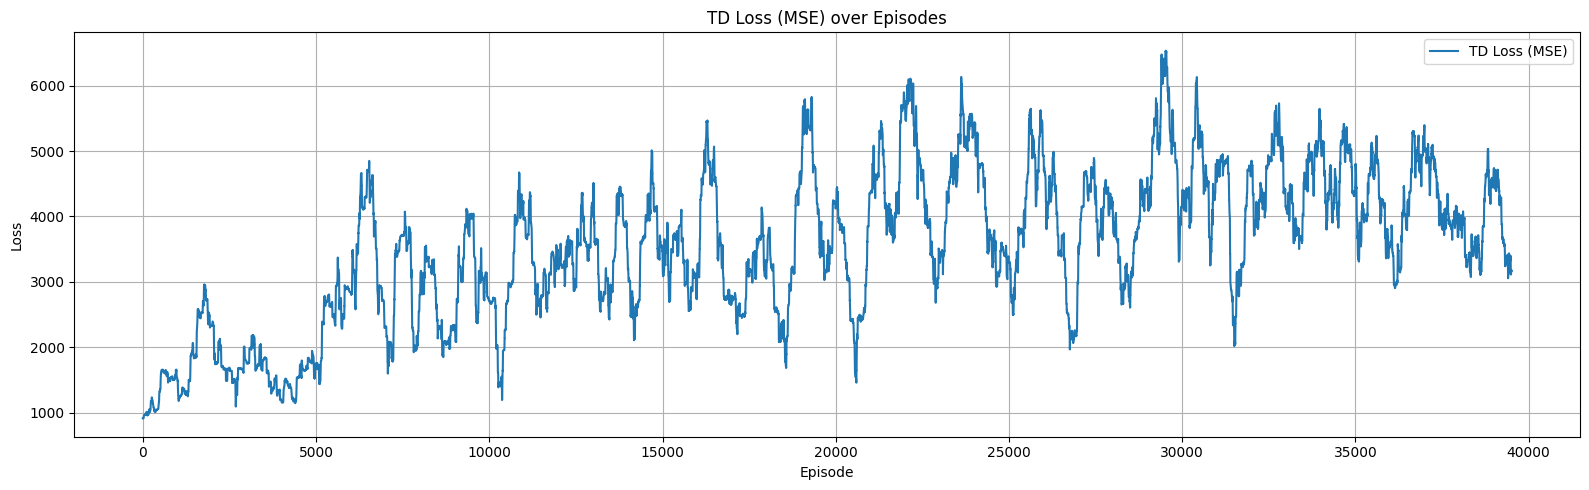

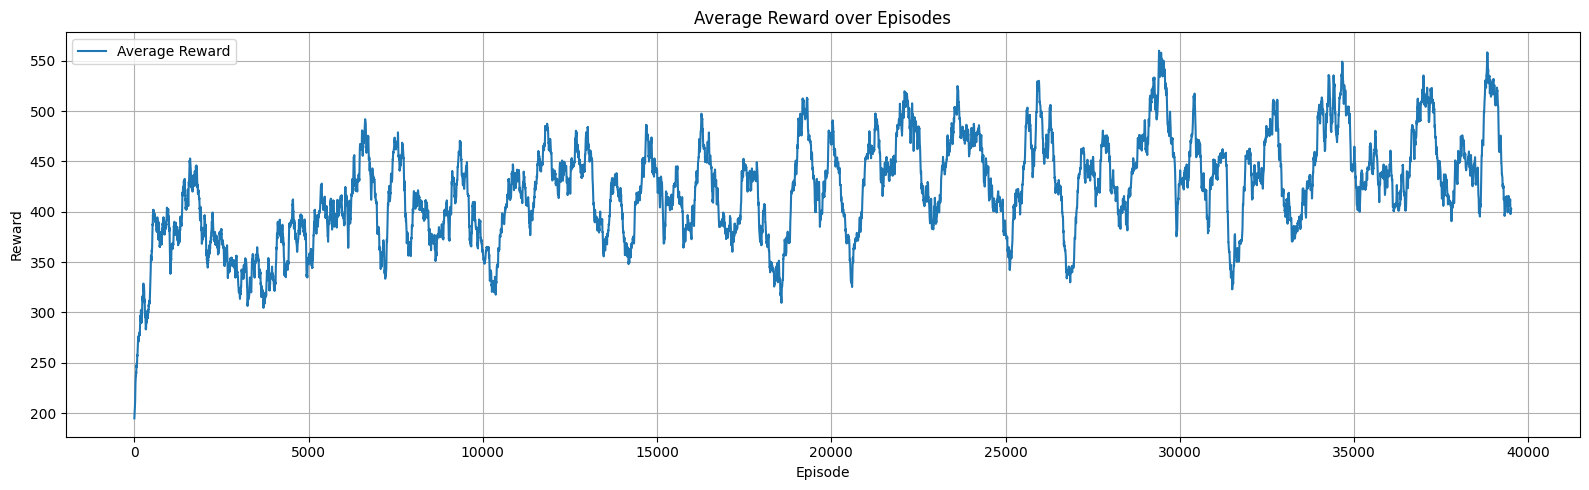

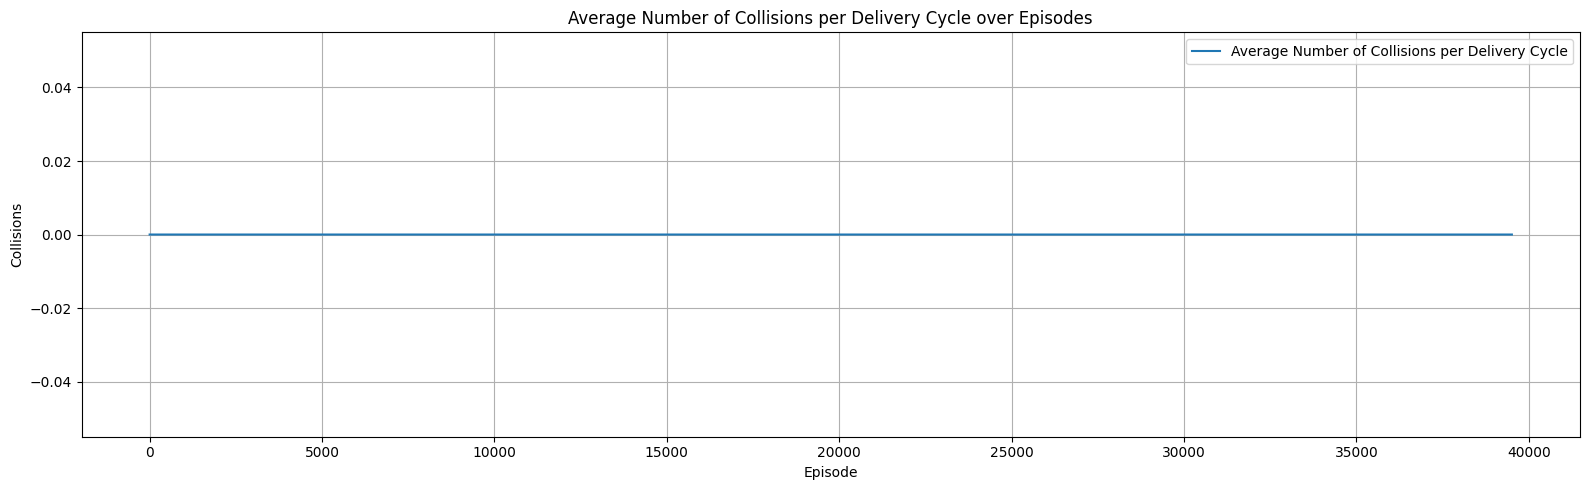

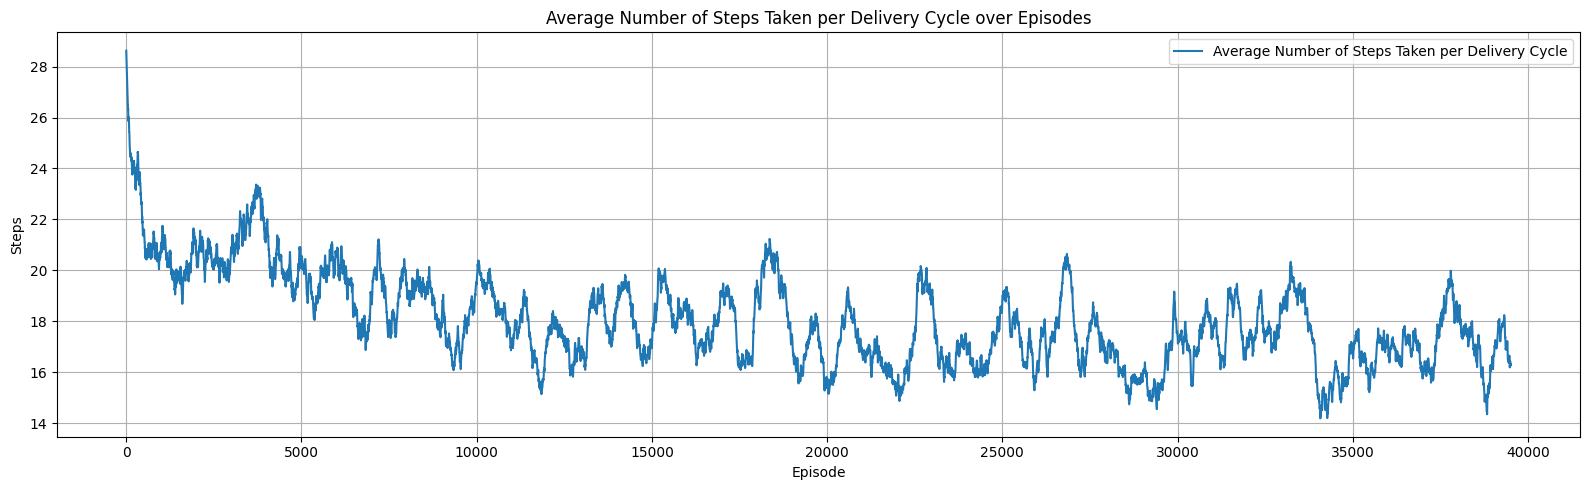

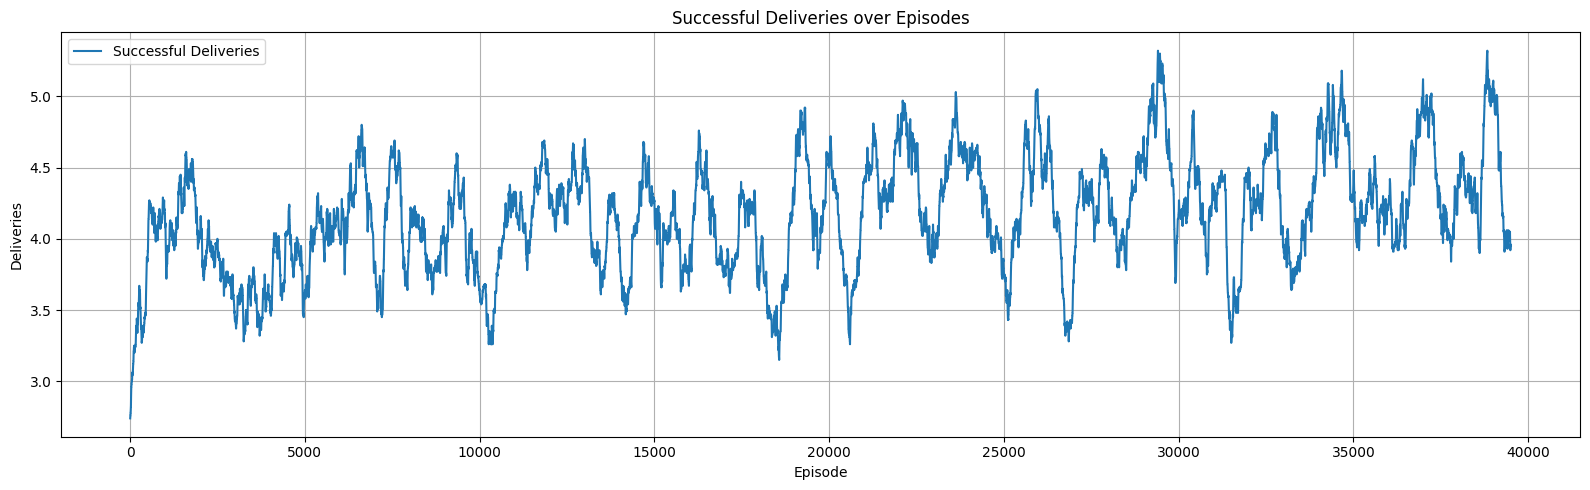

In [98]:
# Plotting training for stage 1
plotter = Plotter(window_size=500)
plotter.plot(trainer.per_stage_metrics[0], loss=True, rewards=True, collisions=True, steps=True, deliveries=True)

The graphs above are the resulting metrics from the first stage of training. Here are the observations:\
* Loss: The TD loss increases steadily over episodes. While this may seem counterintuitive, it's expected as there is no termination condition for the training.
* Rewards: The average reward per episode increases steadily over episodes. This means that the agent is learning to complete more delivery cycles and make better decisions (shorter routes).
* Steps: The average steps per delivery per episode decreases steadily over episodes. This means that the agent is learning more efficient and shorter paths to complete delivery cycles.
* Deliveries: The deliveries per episode increases steadily over episodes. In addition to the decreasing number of steps per delivery, this means that the agent is able to complete more delivery cycles whilst reducing the total number of steps per delivery cycle.

In **`Stage 2`**, the training expands to include two agents instead. This stage focuses on two agents learning how to interact with each other within the environment and avoid collisions while performing delivery cycles.

One key design aspect of the training is that, since we are using a shared Q-table, this means that all agents contribute to and benefit from a single learned policy. Therefore, only two agents are actually required to learn collision avoidance and coordination effectively. Conversely, if we increase the number of agents during training to four, this would significantly increase the number of collisions during training, giving us less amount of overall training due to the pre-defined training limits. As a result, by training with just two agents, we allow the agents to complete more delivery cycles while avoiding collisions during training.

Some key decisions were made regarding the training parameters:
* `episodes=6000`: A significantly high number of episodes was used to train the agents as much as possible before reaching the training limits.
* `agent_min_epsilon=0.001`: We want agents to learn how to avoid collisions more efficiently in the long run, therefore a very low minimum epsilon value is set.
* `agent_decay=0.001`: We want agents to learn how to avoid collisions more efficiently whilst maintaining a low number of collisions during training, hence a lower epsilon decay rate is used to encourage agents to explore more options.
* `early_stop=True`: Early stopping was enabled to reduce the total number of collisions during training. As the agents were already trained to shuttle indefinitely between A and B in stage 1, we want to put more emphasis on training more variations of A, B and agent spawn locations whilst learning to avoid collisions.

In [99]:
# Stage 2: Two-agent training for learning collisions additionally
all_stage_metrics = trainer.run_training_stage(2, size_x=5, size_y=5, episodes=10000, steps_per_episode=50, agent_min_epsilon=0.001, agent_decay=0.001)

# Saving Q-table
trainer.save_q_table("q-table.npy")


Training Stage 2 - 2 agent(s) on 5x5 grid
[Episode 0] Avg Reward: 46.56 | Avg Deliveries: 1.41 | Avg Collisions: 0.38 | Avg Steps: 23.52 | Avg Loss: 5337.05 | Epsilon: 0.00
[Episode 100] Avg Reward: 72.16 | Avg Deliveries: 1.26 | Avg Collisions: 0.37 | Avg Steps: 33.48 | Avg Loss: 6791.64 | Epsilon: 0.00
[Episode 200] Avg Reward: 89.02 | Avg Deliveries: 1.25 | Avg Collisions: 0.11 | Avg Steps: 22.13 | Avg Loss: 4052.68 | Epsilon: 0.00
[Episode 300] Avg Reward: 118.48 | Avg Deliveries: 1.24 | Avg Collisions: 0.02 | Avg Steps: 30.72 | Avg Loss: 816.69 | Epsilon: 0.00
[Episode 400] Avg Reward: 114.43 | Avg Deliveries: 1.48 | Avg Collisions: 0.08 | Avg Steps: 10.34 | Avg Loss: 3963.40 | Epsilon: 0.00
[Episode 500] Avg Reward: 92.50 | Avg Deliveries: 1.15 | Avg Collisions: 0.09 | Avg Steps: 31.03 | Avg Loss: 1228.23 | Epsilon: 0.00
[Episode 600] Avg Reward: 87.68 | Avg Deliveries: 1.32 | Avg Collisions: 0.06 | Avg Steps: 32.04 | Avg Loss: 1036.44 | Epsilon: 0.00
[Episode 700] Avg Reward: 6

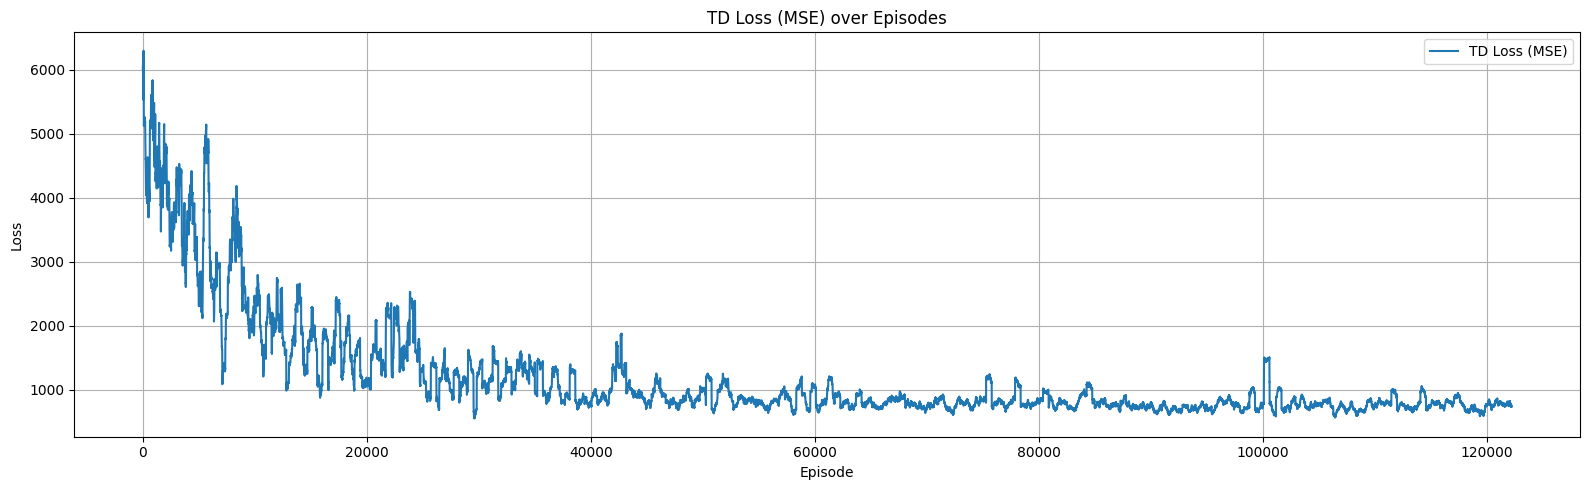

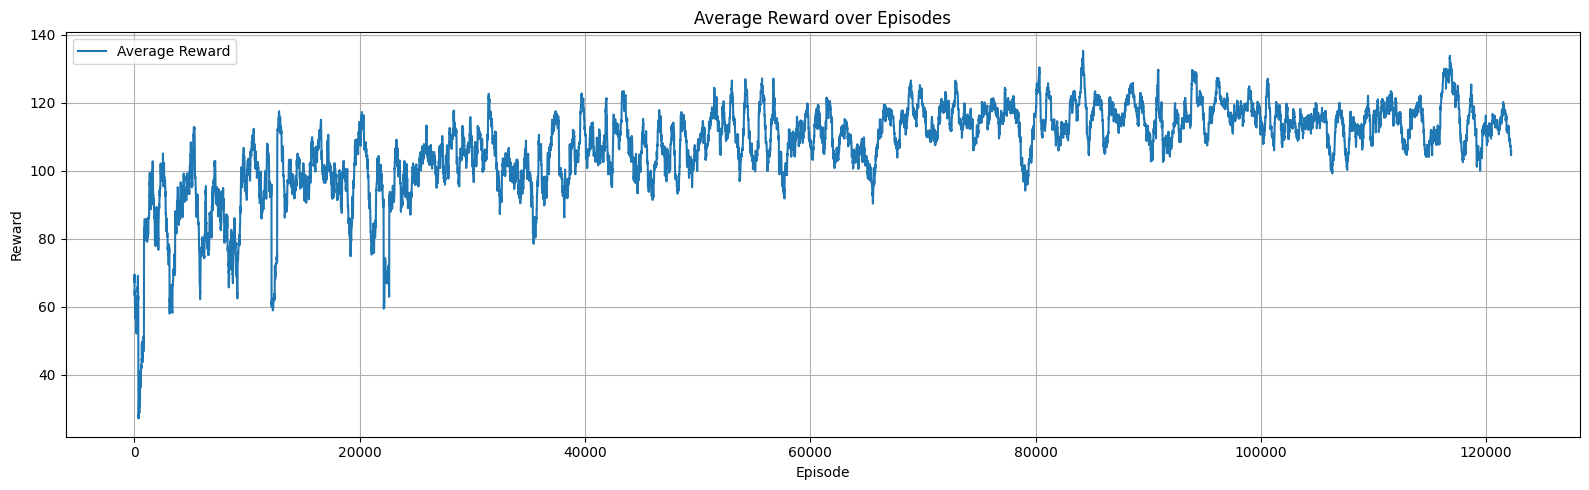

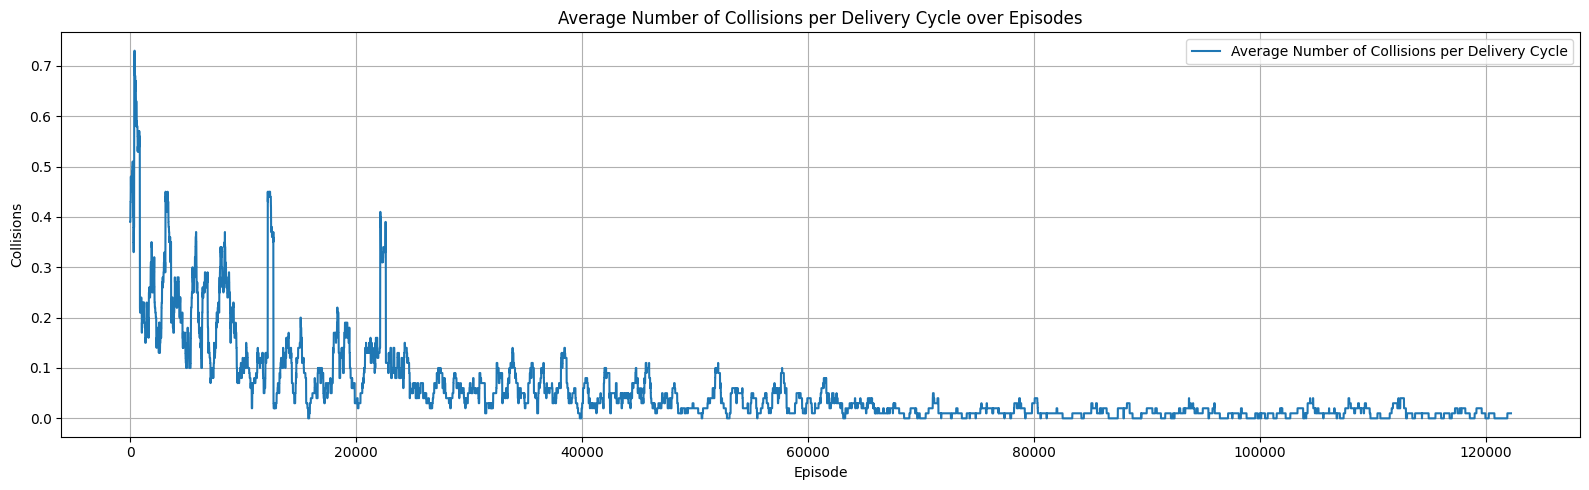

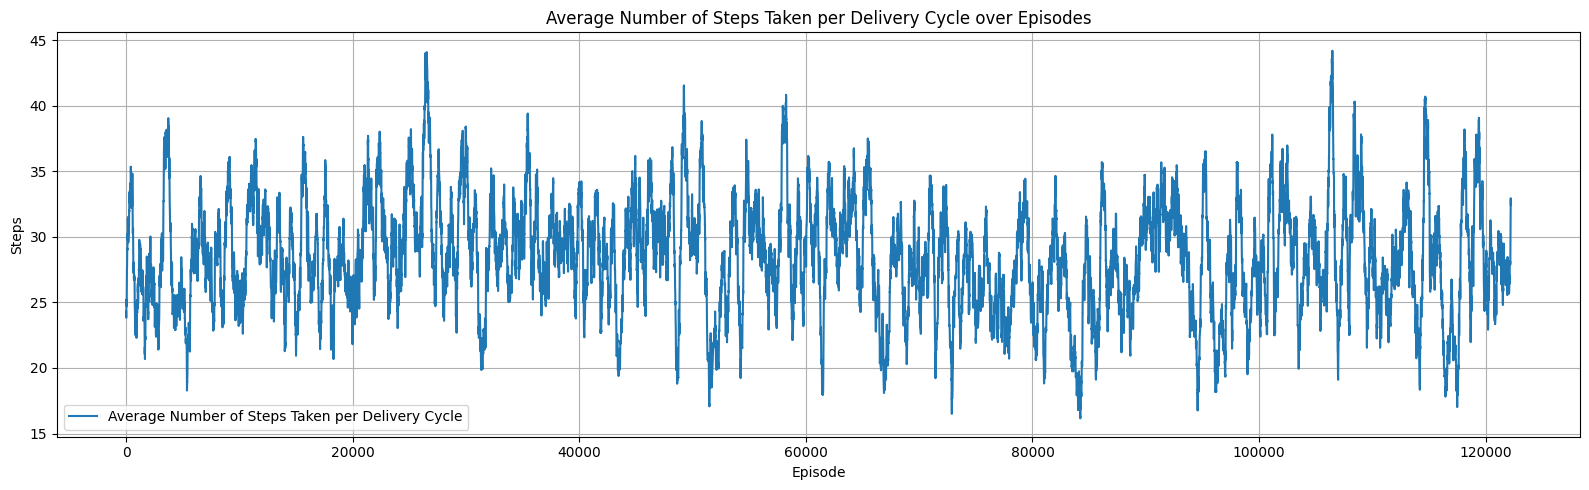

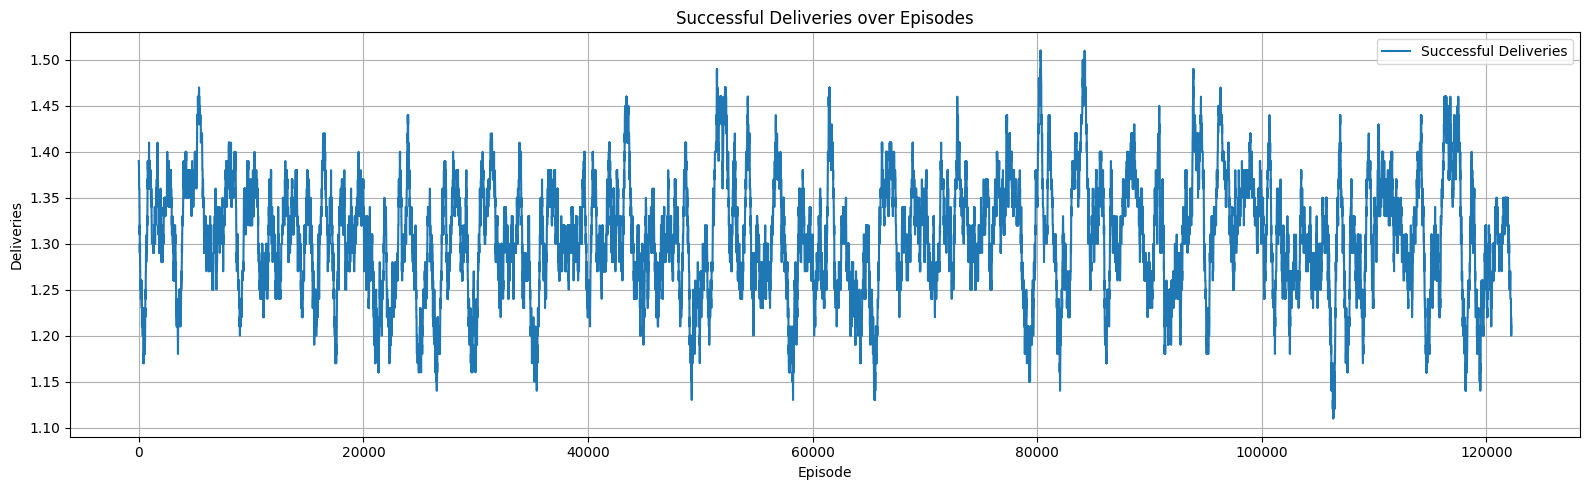

In [100]:
# Plotting training for stage 2
plotter = Plotter(window_size=500)
plotter.plot(trainer.per_stage_metrics[1], loss=True, rewards=True, collisions=True, steps=True, deliveries=True)

The graphs above are the resulting metrics from the second stage of training. Here are the observations:
* Loss: The TD loss decreases steadily over episodes as the agents converge toward accurate Q-value estimates, reflecting stabilization of learning. In addition, a termination condition is present which was not in stage 1.
* Rewards: The average rewards increase steadily over episodes. This shows that agents are successfully avoid collisions (to minimize penalties) and completing delivery cycles (to increase rewards).
* Collisions: The average collisions decrease steadily over episodes. This shows that agents are learning to coordinate and avoid one another.
* Steps: The average steps per delivery per episode decreases steadily over episodes. This means that the agents are learning more efficient and shorter paths to complete delivery cycles.
* Deliveries: The deliveries per episode increases steadily over episodes. In addition to the decreasing number of steps per delivery, this means that the agents are able to complete more delivery cycles whilst reducing the total number of steps per delivery cycle.

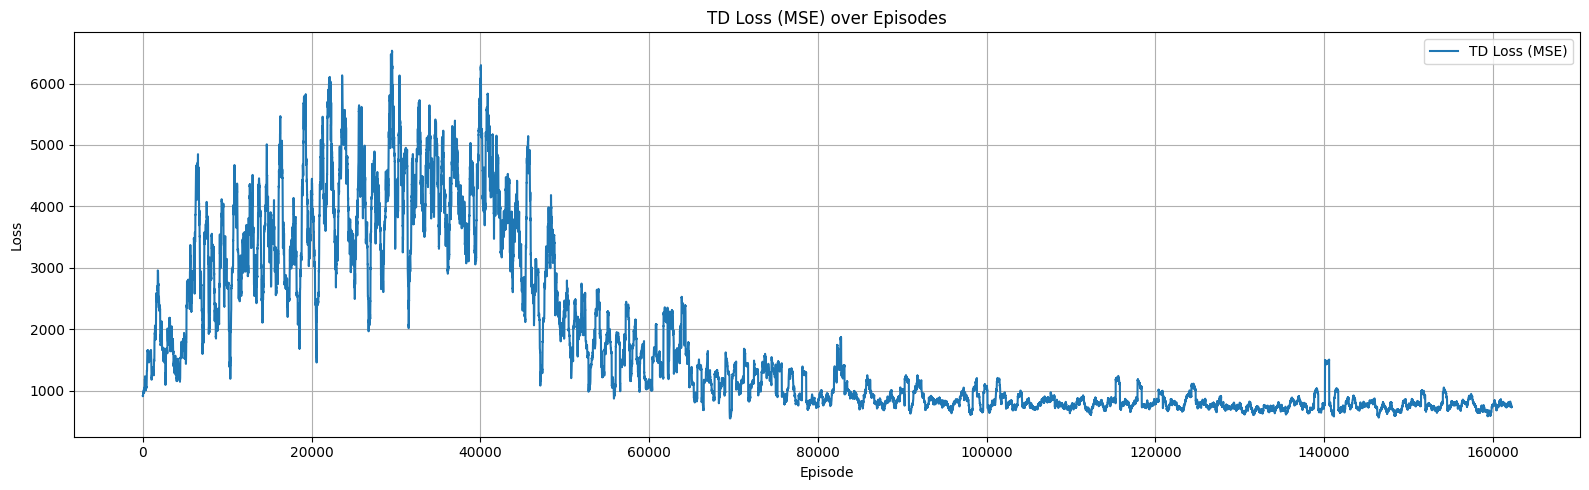

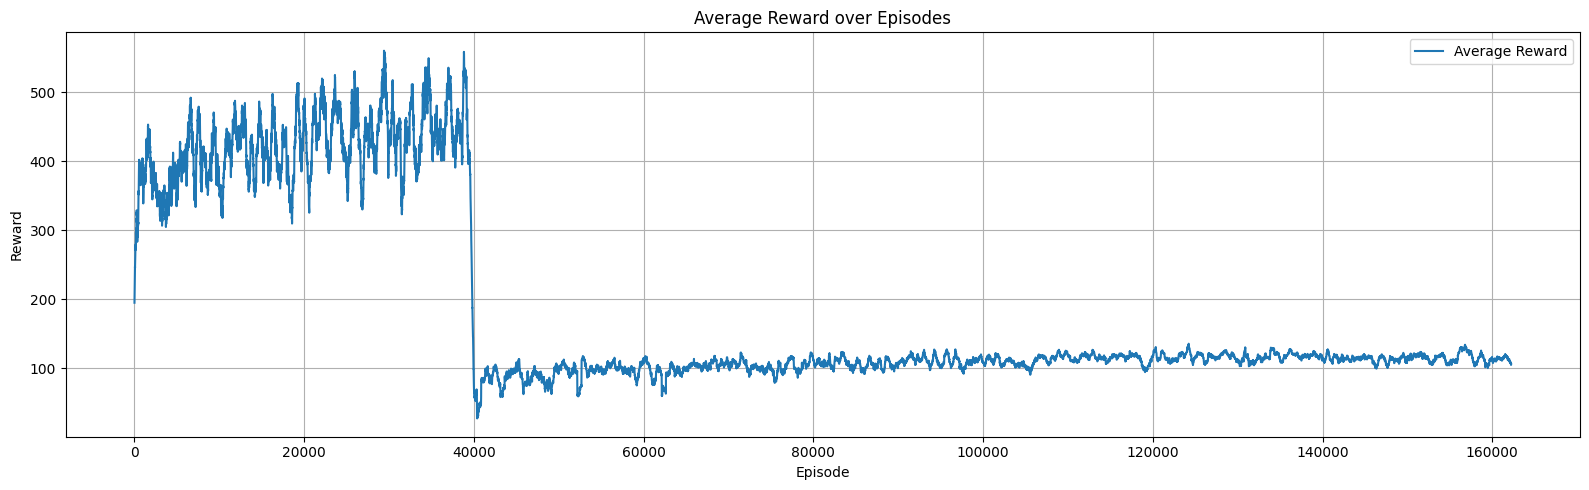

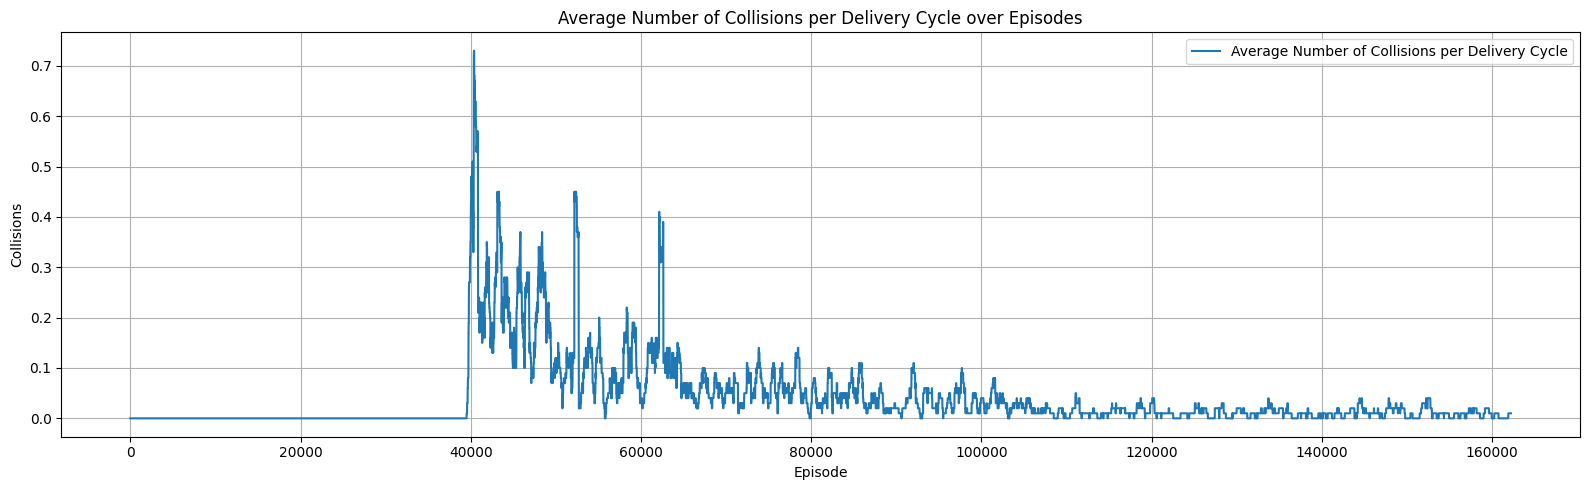

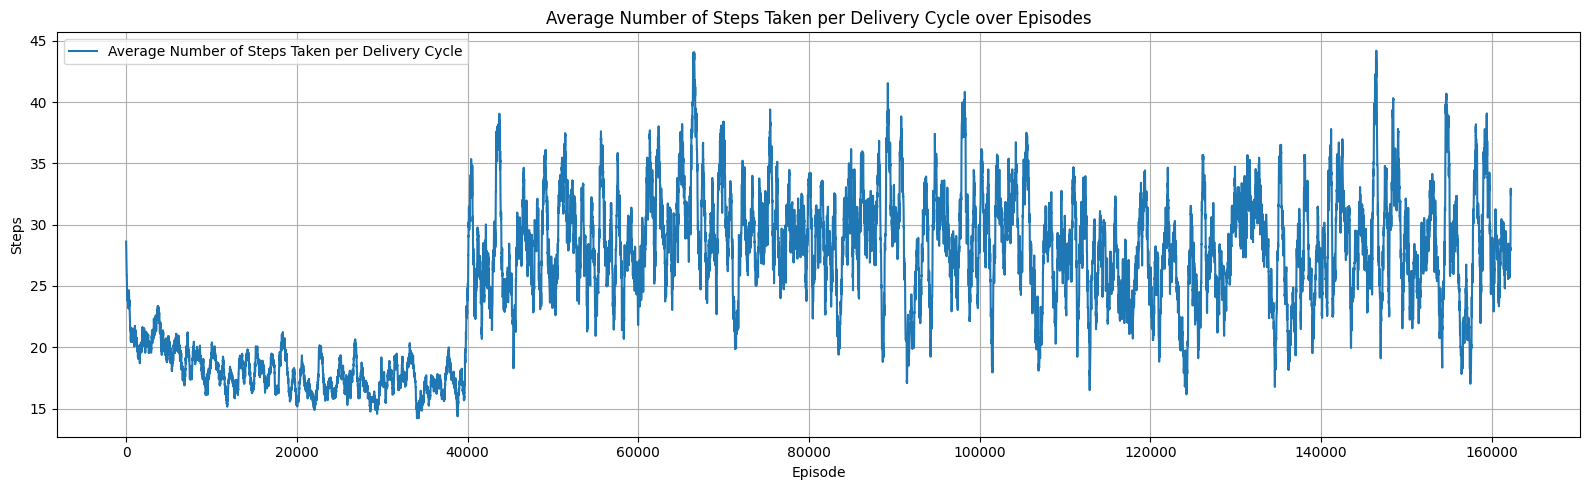

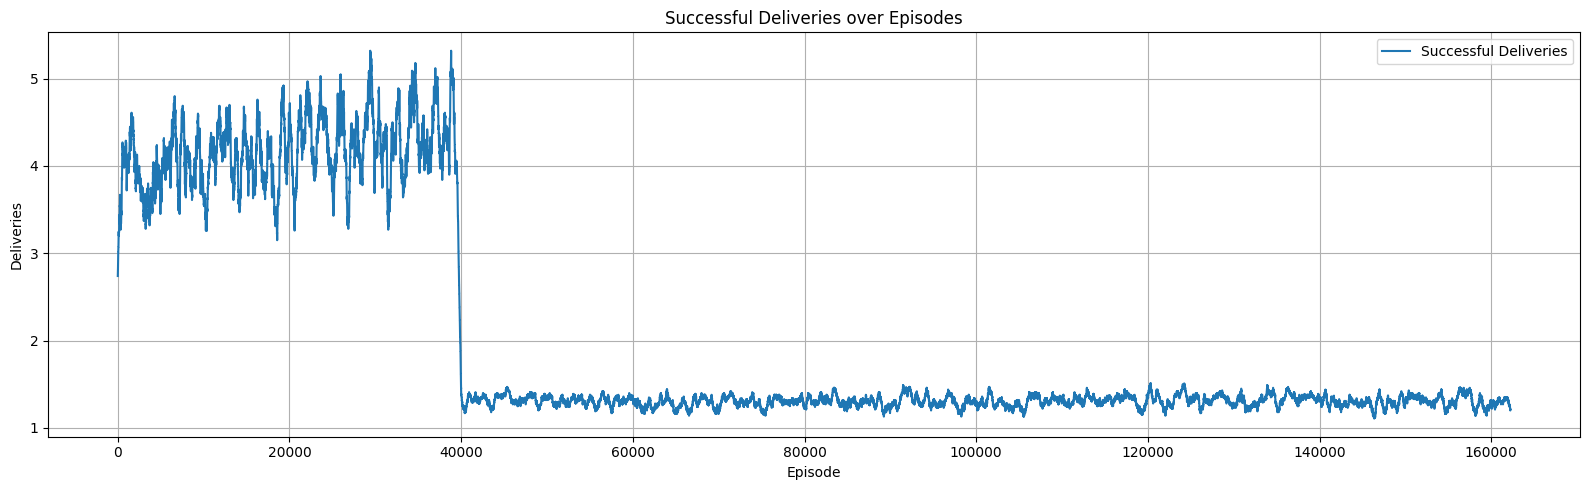

In [101]:
# Plotting metrics across all stages
plotter = Plotter(window_size=500)
plotter.plot(all_stage_metrics, loss=True, rewards=True, collisions=True, steps=True, deliveries=True)

In [102]:
# Stage 3: Four-agent training
all_stage_metrics = trainer.run_training_stage(4, size_x=5, size_y=5, episodes=10000, steps_per_episode=25, agent_min_epsilon=0.001, agent_decay=0.001)

# Saving Q-table
trainer.save_q_table("q-table.npy")


Training Stage 3 - 4 agent(s) on 5x5 grid
Stage 3 complete. Reason for stopping: Step limit reached
Q-table saved to q-table.npy


<div class="alert alert-block alert-success">

## Testing

</div>

The trained agents were evaluated on a total of `9600` unique delivery scenarios, achieving a final success rate `>85%` in under `1000` collisions, `100000` steps distributed into `250000` steps per agent, and within `600` seconds.

In [103]:
# Testing trained agents
tester = Tester(size_x=5, size_y=5, trainer=trainer, num_agents=4)
tester.run(option_cost=0)

 Total scenarios: 9600

 Final Success Rate: 96.12% (9228/9600)

 Total Errors: Incomplete Deliveries: 300 Collisions: 72 Too Many Steps: 300

 Training Steps: 9999976   Training Steps Per Agent: [6000188, 3999788, 0, 0]

 Collisions: 6712   Training Time: 11.172880172729492 seconds

 Raw Score: 1.0/1.00


<div class="alert alert-block alert-success">

## Simulation

</div>

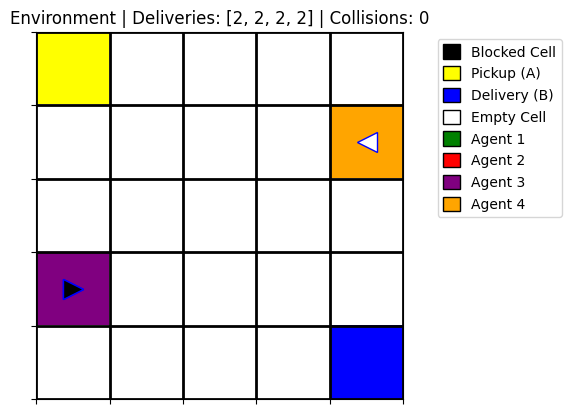

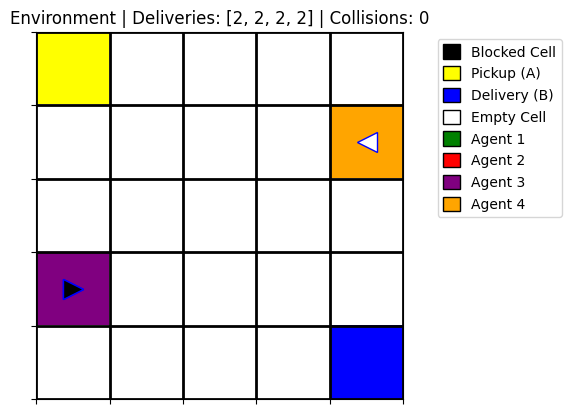


Simulation manually stopped by user.

Final Statistics:
Estimated Deliveries: [2, 2, 2, 2]
Total Collisions: 0


In [132]:
# Simulation for one trainer (Q-table)
sim = Simulator(size_x=5, size_y=5, trainer=trainer, num_agents=4, delay=0.5, max_steps=500, blocked_cells=[], debug=False)
# sim.run()

# Simulation for one trainer (Q-table) with fixed A, B and agent locations
A = (0, 0)
B = (4, 4)
sim.run(custom_A = A, custom_B = B, custom_spawns = [A, A, A, B])

In [1]:
# Simulation by loading an existing Q-table into trainer
# loaded_trainer = Trainer(q_table_path="q-table.npy")
# sim = Simulator(size_x=5, size_y=5, trainer=loaded_trainer, num_agents=4, delay=0.5, max_steps=500, blocked_cells=[], debug=False)
# sim.run()

# Simulation by loading an existing Q-table into trainer with fixed A, B and agent locations
# A = (1, 1)
# B = (3, 3)
# sim.run(custom_A = A, custom_B = B, custom_spawns = [A, A, A, B])

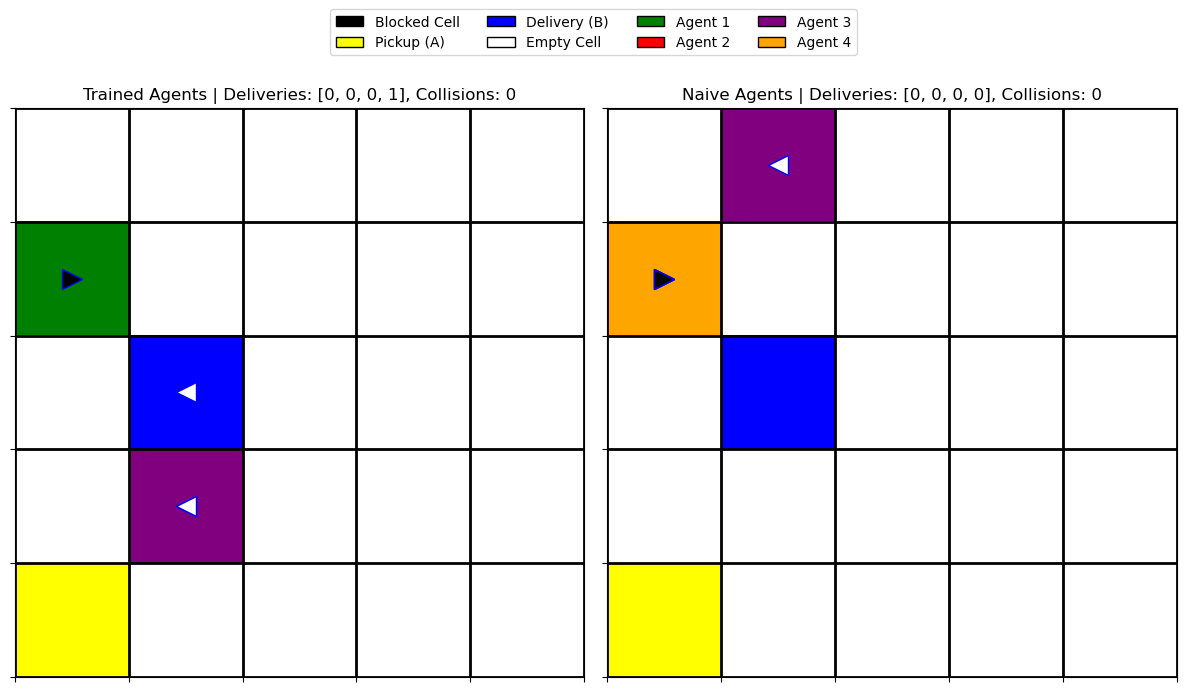

Simulation manually stopped by user.

Final Statistics:
Trained Agents: Deliveries=[0, 0, 0, 1], Collisions=0
Naive Agents: Deliveries=[0, 0, 0, 0], Collisions=0


In [479]:
# Comparing different trainers
sim = Simulator(size_x=5, size_y=5, trainer=trainer, num_agents=4)
sim.compare_trainer(Trainer(), label1="Trained Agents", label2="Naive Agents")

# Comparing different trainers with fixed A, B and agent locations
# sim.compare_trainer(Trainer(), label1="Trained Agents", label2="Naive Agents", custom_A=(0,0), custom_B=(4,4))